In [1]:
import json
import os

from analysis import *
from plot_main import *
from choice_analysis import *

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'


# %load_ext autoreload
# %autoreload 0

### Load model and run simulation on experimental reward schedule and stimuli

In [2]:
# exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/no_rwd_input/'
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/test/'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')
# os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
# exp_dir = 'exp/dual_hierarchical_good_based_2_area_no_choice_to_area_1'

f = open(os.path.join(exp_dir, 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.2
choice_start = 0.6
rwd_start = 0.85
stim_end = 0.95
mask_onset = 0.4
# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.2          , 0.6         , 0.15                   , 0.15                  ]

exp_times = {
    'start_time': -ITI,
    'end_time': stim_end,
    'stim_onset': 0.0,
    'stim_end': stim_end,
    'mask_onset': mask_onset,
    'mask_end': choice_start,
    'choice_onset': choice_start,
    'choice_end': stim_end,
    'rwd_onset': rwd_start,
    'rwd_end': stim_end,
    'total_time': ITI+stim_end,
    'dt': args['dt']}
log_interval = 1


input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'sep_lr': args['sep_lr'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']

model = HierarchicalRNN(**model_specs)
print(model)
for n, p in model.named_parameters():
    print(n, p.numel())
    
# plt.scatter(torch.linalg.eigvals(model.rnn.h2h.effective_weight().detach()).real, 
#             torch.linalg.eigvals(model.rnn.h2h.effective_weight().detach()).imag)
# plt.plot(torch.linalg.eig(model.rnn.h2h.effective_weight().detach())[1].real[:,0])
# print(np.abs(torch.linalg.eigvals(model.rnn.h2h.effective_weight().detach())))
# plt.plot()

state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth.tar'), map_location=torch.device('cpu'))['model_state_dict']
print(model.load_state_dict(state_dict))

loaded args
0.369
21
HierarchicalRNN(
  (rnn): PlasticLeakyRNNCell(
    (x2h): EILinear()
    (aux2h): EILinear()
    (h2h): EILinear()
  )
  (h2o): EILinear()
)
rnn.kappa_rec 25600
rnn.x2h.weight 10080
rnn.aux2h.weight 4320
rnn.h2h.weight 25600
rnn.h2h.bias 160
h2o.weight 1728
<All keys matched successfully>


In [47]:
def run_model(args, model, task_mdprl, n_samples=None):
    model.eval()
    all_saved_states = defaultdict(list)
    output_size = args['output_size']

#     all_dim_orders = list(itertools.permutations(range(1, 4)))
#     all_dim_orders = [list(dim_order) for dim_order in all_dim_orders]

    for p in model.parameters():
        p.requires_grad = False # disable gradient calculation for parameters

    if n_samples is None:
        n_samples = task_mdprl.test_stim_order.shape[1]
    for batch_idx in tqdm.tqdm(range(n_samples)):
        # sample random order to permute reward schedule dimensions
#             curr_dim_order = all_dim_orders[np.random.choice(len(all_dim_orders))]
        pop_s, rwd_s, target_valid, output_mask, rwd_mask, ch_mask, index_s, prob_s = task_mdprl.generateinputfromexp(
            batch_size=1, test_N_s=args['test_N_s'], num_choices=args['num_options'], participant_num=batch_idx)
#             all_saved_states['dim_orders'].append(torch.from_numpy(np.expand_dims(np.array(curr_dim_order), axis=(0,1,2)))) # num trials (1) X time_steps(1) X batch_size(1) X num_dims
        # add empty list for the current episode
        all_saved_states['whs_final'].append([])

        all_saved_states['stimuli'].append(torch.from_numpy(np.expand_dims(index_s, axis=(1,2)))) # num trials X time_steps(1) X batch_size(1) X num_choices
        all_saved_states['reward_probs'].append(torch.from_numpy(np.expand_dims(prob_s, axis=(1,)))) # num_trials X time_steps(1) X batch_size X num_choices
        

        all_saved_states['choices'].append([])
        all_saved_states['foregone'].append([])
        all_saved_states['rewards'].append([])
        all_saved_states['choose_better'].append([])
        
        all_saved_states['hs_pre'].append([])
        all_saved_states['hs_post'].append([])

#         all_saved_states['sensitivity'].append([])

        # reinitialize hidden layer activity
        hidden = None

        for i in range(len(pop_s['pre_choice'])):
            # first phase, give stimuli and no feedback
            output, hs, hidden, ss = model(pop_s['pre_choice'][i], hidden=hidden, 
                                            DAs=torch.zeros(1, args['batch_size'], 1)*rwd_mask['pre_choice'],
                                            Rs=torch.zeros(1, args['batch_size'], 2)*rwd_mask['pre_choice'],
                                            acts=torch.zeros(1, args['batch_size'], output_size)*ch_mask['pre_choice'],
                                            save_weights=True)

            # save activities before reward
            all_saved_states['hs_pre'][-1].append(hs.detach()) # [num_sessions, [num_trials, [time_pre, num_batch_size, hidden_size]]]

            if args['task_type']=='on_policy_double':
                # use output to calculate action, reward, and record loss function
                if args['decision_space']=='action':
                    action = torch.argmax(output[-1,:,:], -1) # batch size
                    rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action]).float()
                    all_saved_states['choose_better'][-1].append((action==torch.argmax(prob_s[i], -1)).float().squeeze())
                elif args['decision_space']=='good':
                    # action_valid = torch.argmax(output[-1,:,index_s[i]], -1) # the object that can be chosen (0~1), (batch size, )
                    action_valid = torch.multinomial(output[-1,:,index_s[i]].softmax(-1), num_samples=1).squeeze(-1)
                    # backpropagate from choice to previous reward
#                     if i>0 and i<108:
#                         grad_logit_rwd = torch.empty(args['output_size'])
#                         for out_idx in range(args['output_size']):
#                             output_mask = torch.zeros(args['output_size'])
#                             output_mask[out_idx] = 1
#                             output[-1,:,:].sum(0).backward(gradient=output_mask, 
#                                                            retain_graph=True if out_idx<args['output_size']-1\
#                                                                           else False)
#                             grad_logit_rwd[out_idx] = rwd.grad
#                             rwd.grad = None
#                         all_saved_states['sensitivity'][-1].append(grad_logit_rwd[None,...])
#                     else:
#                         all_saved_states['sensitivity'][-1].append(torch.zeros(1, args['output_size']))
                    
                    action = index_s[i, action_valid] # (batch size, )
                    nonaction = index_s[i, 1-action_valid] # (batch size, )
                    # rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action_valid]).long()
                    rwd = rwd_s[i][range(args['batch_size']), action_valid]
                    all_saved_states['choose_better'][-1].append((action_valid==torch.argmax(prob_s[i], -1)).float()[None,...]) 
                all_saved_states['rewards'][-1].append(rwd.float()[None,...])
                all_saved_states['choices'][-1].append(action[None,...])
                all_saved_states['foregone'][-1].append(nonaction[None,...])
            elif args['task_type'] == 'value':
                raise NotImplementedError
                rwd = (torch.rand(1)<prob_s[i]).float()
                output = output.reshape(output_mask['target'].shape[0], 1, output_size)
                acc.append(((output-target_valid['pre_choice'][i])*output_mask['target'].float().unsqueeze(-1)).pow(2).mean(0)/output_mask['target'].float().mean())
                curr_rwd.append(rwd)
            
            if args['task_type']=='on_policy_double':
                # use the action (optional) and reward as feedback
                pop_post = pop_s['post_choice'][i]
                action_enc = torch.eye(output_size)[action]
                rwd_enc = torch.eye(2)[rwd]
                action_enc = action_enc*ch_mask['post_choice']
                rwd_enc = rwd_enc*rwd_mask['post_choice']
                rwd = rwd.float().requires_grad_()
                DAs = (2*rwd-1)*rwd_mask['post_choice']
                for h_idx, h in enumerate(hidden):
                    hidden[h_idx] = hidden[h_idx].detach()
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=action_enc, DAs=DAs, save_weights=False)
            elif args['task_type'] == 'value':
                raise NotImplementedError
                pop_post = pop_s['post_choice'][i]
                rwd_enc = torch.eye(2)[rwd]
                DAs = (2*rwd.float()-1)*rwd_mask['post_choice']
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=None, DAs=DAs, save_weights=False)
            
            all_saved_states['hs_post'][-1].append(hs.detach()) # [num_sessions, [num_trials, [time_post, num_batch_size, hidden_size]]]
            all_saved_states['whs_final'][-1].append(hidden[2][None,...].detach()) 
                # [num_sessions, [num_trials, [1, num_batch_size, hidden_size, hidden_size]]]

        # stack to create a trial dimension for each session
        for k in all_saved_states.keys():
            if isinstance(all_saved_states[k][-1], list):
                all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
        # [num_sessions, [num_trials, time_steps, num_batch_size, ...]]

    # concatenate all saved states along the batch dimension
    for k in all_saved_states.keys():
        all_saved_states[k] = torch.cat(all_saved_states[k], axis=2) # [num_trials, time_steps, num_sessions, ...]
        
    # all saved states of the form [num_trials, time_steps, num_sessions, ...]

    # concatenate activities pre- and post-feedback
    all_saved_states['hs'] = torch.cat([all_saved_states['hs_pre'], all_saved_states['hs_post']], dim=1)

    # concatenate all accuracies and rewards
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
    
    for k, v in all_saved_states.items():
        print(k, v.shape)
    
    return all_saved_states


In [8]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/test_activities'
test_task_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/task_mdprl'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    with open(test_task_dir, 'rb') as f:
        task_mdprl = pickle.load(f)
    print('loaded previous results')
else:
    task_mdprl = MDPRL(exp_times, args['input_type'])
    print('loaded task')
    with open(test_task_dir, 'wb') as f:
        pickle.dump(task_mdprl, f)
    print(f'saved task to {test_task_dir}')
    all_saved_states = run_model(args, model, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')

found previous record pickle, loading previous results
loaded previous results


### Learning Curve

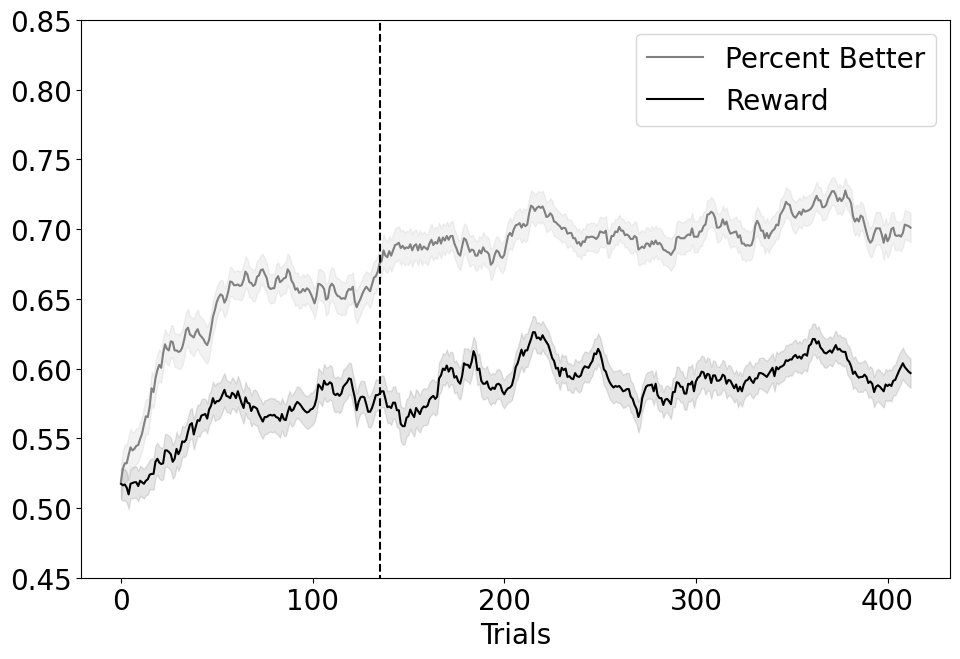

In [254]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'])

Finished calculating norm of update
Finished calculating weight norms
Finished calculating variability


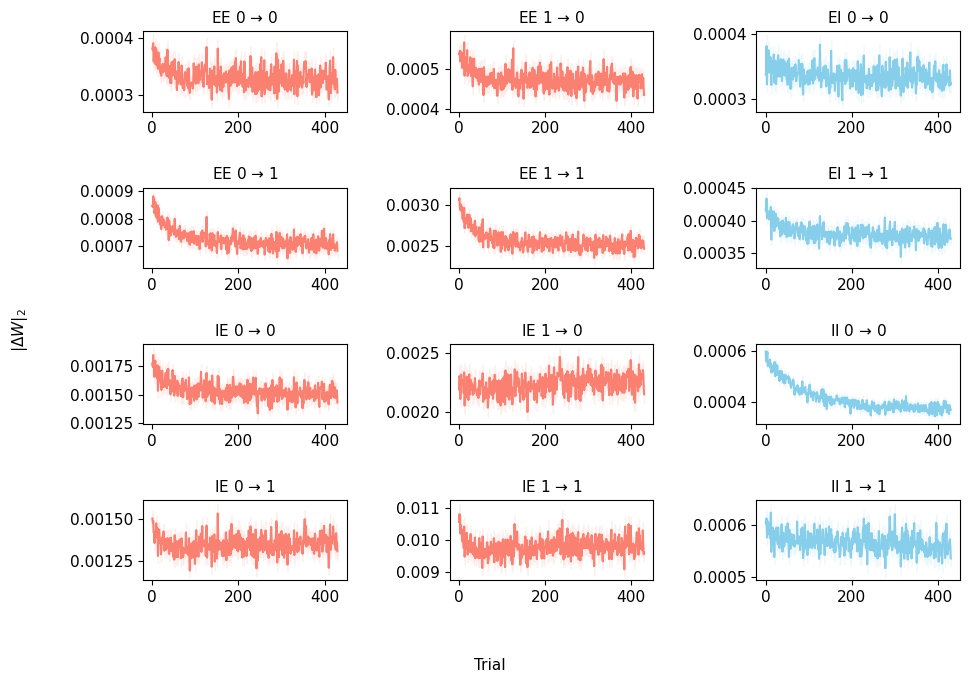

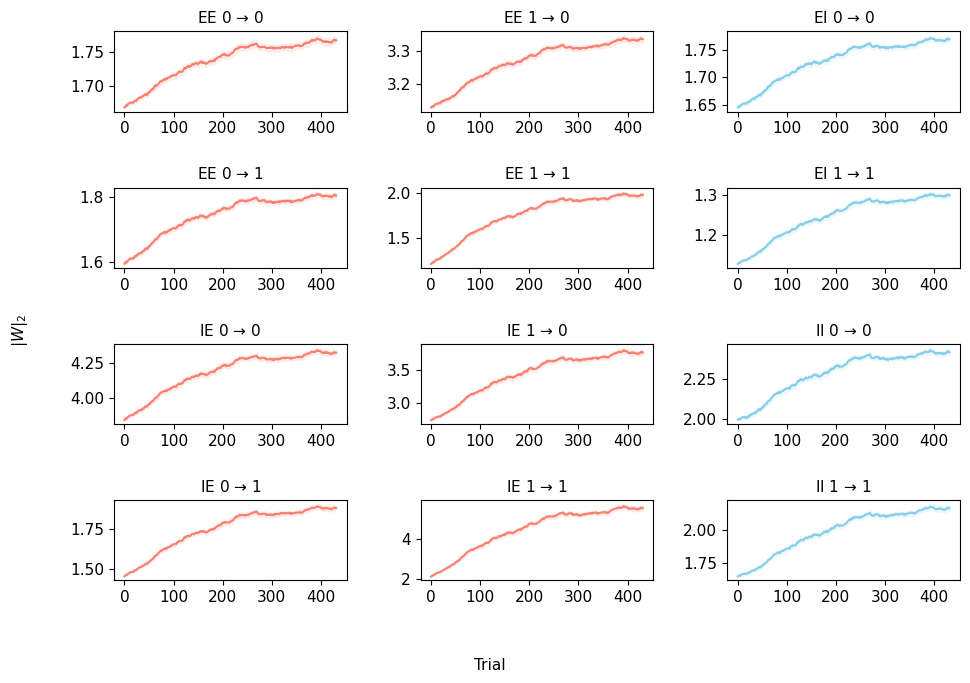

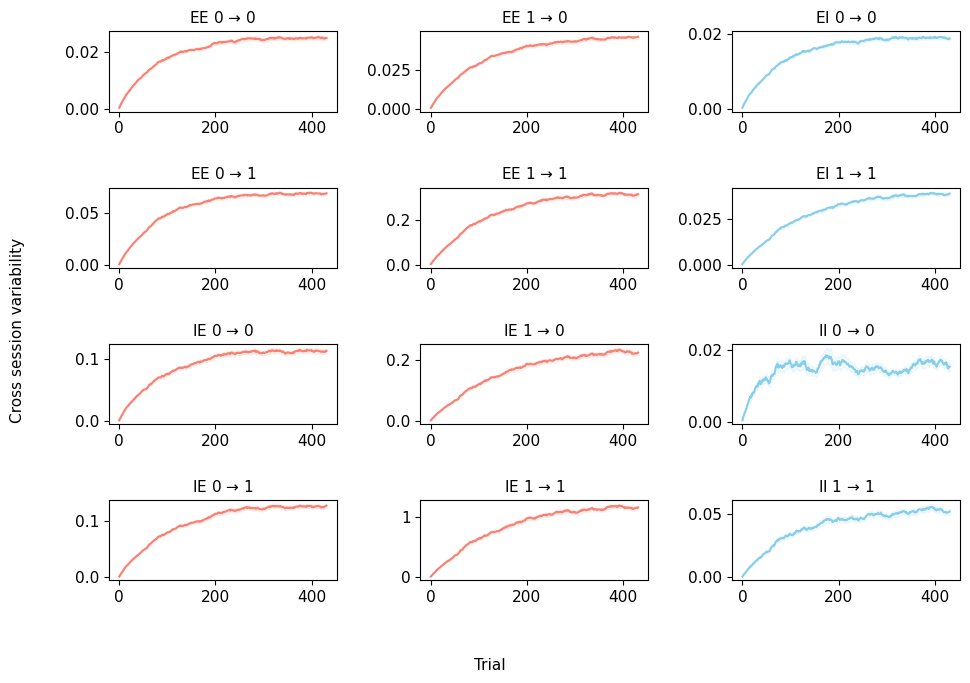

In [255]:
# all_saved_states['whs_final'].shape
plot_weight_summary(args, all_saved_states['whs_final']*model.rnn.h2h.mask, 
                    model.rnn.h2h.effective_weight().detach())

# Behavioral Analysis

In [256]:
def obj_to_ft_conj(obj, task_mdprl):
    F1 = task_mdprl.index_shp[obj]
    F2 = task_mdprl.index_pttrn[obj]
    F3 = task_mdprl.index_clr[obj]

    C1 = task_mdprl.index_pttrnclr[obj]
    C2 = task_mdprl.index_shpclr[obj]
    C3 = task_mdprl.index_shppttrn[obj]

    return np.stack([F1, F2, F3, C1, C2, C3, obj], axis=-1)

def obj_to_value_est(obj, task_mdprl):
    pF1, pF2, pF3, pC1, pC2, pC3, pO = task_mdprl.value_est()

    return pF1[obj], pC1[obj], pO[obj]

def steady_state_choice_analysis(all_saved_states, task_mdprl):
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(432-216, num_trials)
    num_subj = all_saved_states['rewards'].shape[2]

    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        # stim in sensory space, ntrials X 2
        stims = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] 
        # stim back to reward schedule space, ntrials X 2
        stims_rwd_mat = task_mdprl.permute_mapping(stims, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        pF1, pC1, pO = obj_to_value_est(stims_rwd_mat, task_mdprl) # ntrials X 2 for each
        # choices are in sensory space, map back to schedule space
        choices = all_saved_states['choices'][num_trials_to_fit,0,idx_subj]
#         choices = task_mdprl.permute_mapping(choices, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = choices==stims[:,1] # ntrials

        all_Xs.append(np.stack([np.log(pF1[:,1]/pF1[:,0]), 
                                np.log(pC1[:,1]/pC1[:,0]),
                                np.log(pO[:,1]/pO[:,0]),], axis=1))
        all_Ys.append(choices)
        
    all_Xs = np.concatenate(all_Xs, 0)
    all_Ys = np.concatenate(all_Ys, 0)[:, None]
    

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=['pFinf', 'pCinf', 'pO', 'choice']).fillna(0)
    data_group_by_F_m = all_data.groupby('pFinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_F_se = all_data.groupby('pFinf').sem().apply(np.array).loc[:,'choice']
    data_group_by_C_m = all_data.groupby('pCinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_C_se = all_data.groupby('pCinf').sem().apply(np.array).loc[:,'choice']

    fig, axes = plt.subplots()
    fig.set_size_inches((7, 5))
    axes.errorbar(data_group_by_F_m.index.values, 
                 data_group_by_F_m.values, 
                 data_group_by_F_se.values,
                 c=mpl.colormaps['tab10']([0]),
                 ls='', marker='o', mfc='white')
    axes.errorbar(data_group_by_C_m.index.values, 
                 data_group_by_C_m.values, 
                 data_group_by_C_se.values,
                 c=mpl.colormaps['tab10']([3]),
                 ls='', marker='o', mfc='white')
    

    mdl = smf.glm('choice~pFinf+pCinf+pO', all_data, missing='drop', family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_coeffs = np.stack(all_coeffs)
    all_ses = np.stack(all_ses)
    all_ps = np.stack(all_ps)

    var_names = ['F0', 'C0', 'O']
    
    xs = np.linspace(-1., 1., 100)
    
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[0]*xs)), color=mpl.colormaps['tab10']([0]), label='F0')
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[1]*xs)), color=mpl.colormaps['tab10']([3]), label='C0')
    axes.legend()
    
    
    axin = axes.inset_axes([0.65, 0.1, 0.3, 0.3])
    axin.bar(np.arange(1, len(var_names)+1), all_coeffs, color=mpl.colormaps['tab10']([0, 3, 7]))
    axin.errorbar(np.arange(1, len(var_names)+1), all_coeffs, all_ses, linestyle="", color='k')
    axin.text(1, all_coeffs[0]+all_ses[0]+0.05, convert_pvalue_to_asterisks(all_ps[0]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(2, all_coeffs[1]+all_ses[1]+0.05, convert_pvalue_to_asterisks(all_ps[1]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(3, all_coeffs[2]+np.sign(all_coeffs[2])*(all_ses[2]+0.3), convert_pvalue_to_asterisks(all_ps[2]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.set_ylim([-0.9, 3.5])
    axin.set_xticks(range(1,4), labels=var_names, fontsize=12)
    axin.set_yticks(range(0,4), labels=range(0,4), fontsize=12)
    axin.set_ylabel('Slopes', fontsize=16)
    axes.set_xlabel('Log odd of reward')
    axes.set_ylabel('Choice probability')
#     plt.tight_layout()
#     plt.savefig(os.path.join(figure_data_dir, "choice_curves_slope.pdf"))
    plt.show()
    # plt.close()
    return


def credit_assignment(all_saved_states, task_mdprl):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, 216-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_post = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        stims_pre_chosen = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = all_saved_states['choices'][num_trials_to_fit+1,0,idx_subj]
        choices = task_mdprl.permute_mapping(choices, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = choices==stims_post[:,1]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(choices)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    rw_ch = ['R', 'C']

    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*all_var_names, 'choice'])

    mdl = smf.glm('choice~'+'+'.join(all_var_names), data=all_data, family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_xlabels = var_names

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches((10, 5))
    
    bar_rw = axes[0].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[len(var_names):], \
                yerr=all_ses[len(var_names):], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    axes[0].set_ylabel('Regression weights')
    axes[0].set_xlabel('Win-stay lose-switch')
    axes[1].set_xlabel('Choice autocorrelation')
    axes[0].set_ylim([-0.25, 0.55])
    axes[1].set_ylim([-0.25, 0.55])
    axes[0].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes[0].text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
        
    for i in range(len(var_names)):
        axes[1].text(i+1, all_coeffs[i+len(var_names)]+np.sign(all_coeffs[i+len(var_names)])*(all_ses[i+len(var_names)]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i+len(var_names)]), 
                     verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
#     plt.savefig(os.path.join(figure_data_dir, f"credit_assignment_{num_block}.pdf"))
    plt.show()
    # plt.close()
    return


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19872
Model:                            GLM   Df Residuals:                    19868
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10782.
Date:                Mon, 21 Aug 2023   Deviance:                       21564.
Time:                        17:27:00   Pearson chi2:                 1.97e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2600
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0095      0.017      0.567      0.5

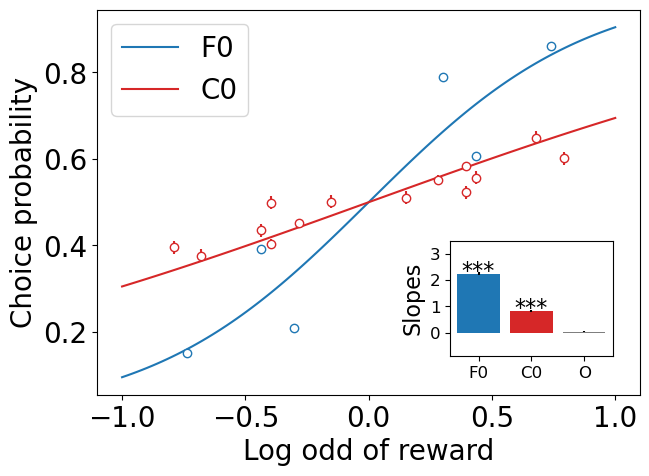

In [257]:
steady_state_choice_analysis(all_saved_states, task_mdprl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19780
Model:                            GLM   Df Residuals:                    19765
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13411.
Date:                Mon, 21 Aug 2023   Deviance:                       26822.
Time:                        17:27:00   Pearson chi2:                 1.98e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02981
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.014     -0.099      0.9

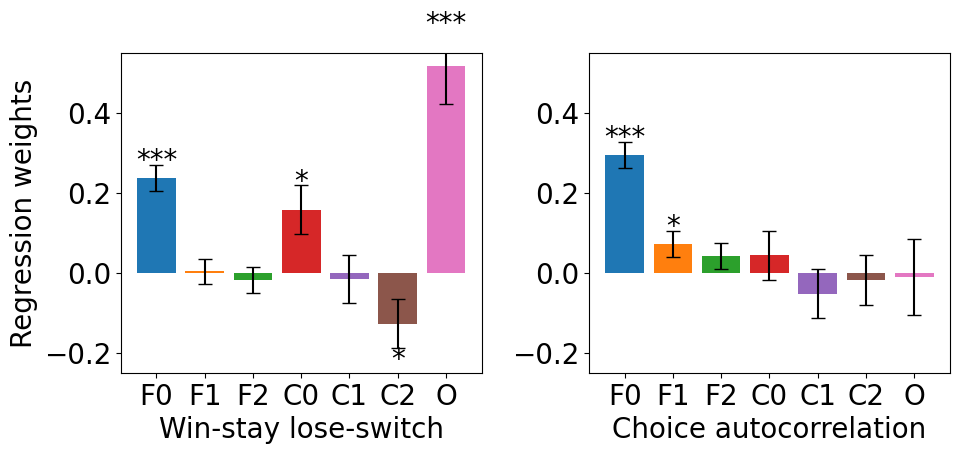

In [258]:
credit_assignment(all_saved_states, task_mdprl)

# Plot Initial Connectivity

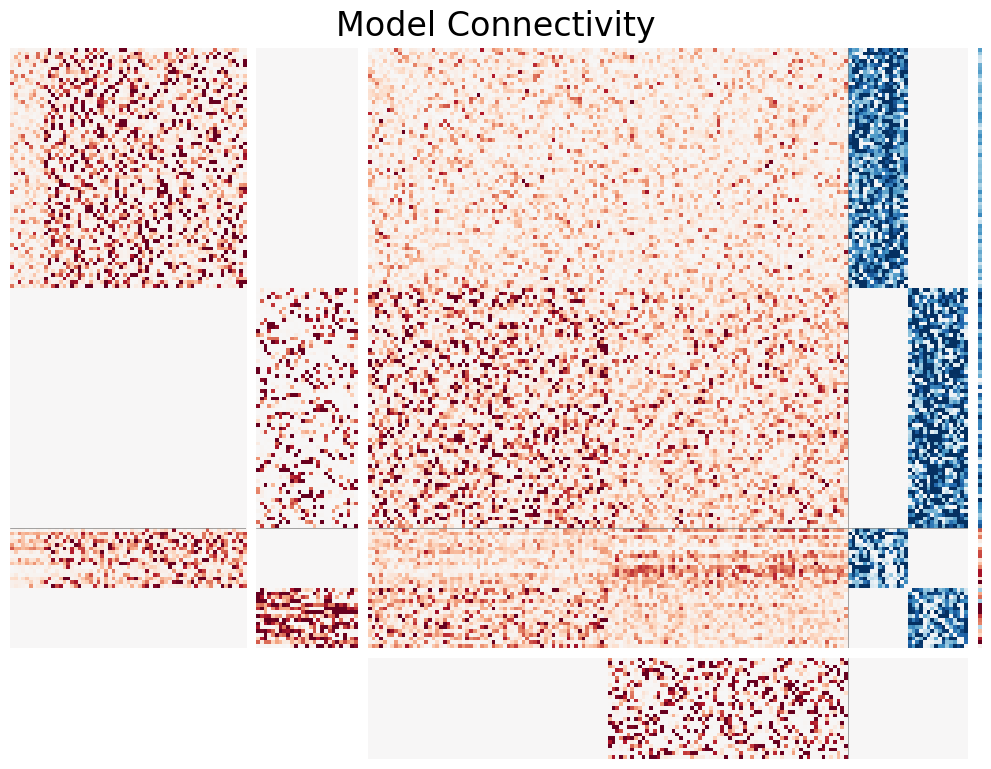

Figure saved at plots/exp/test/connectivity.pdf


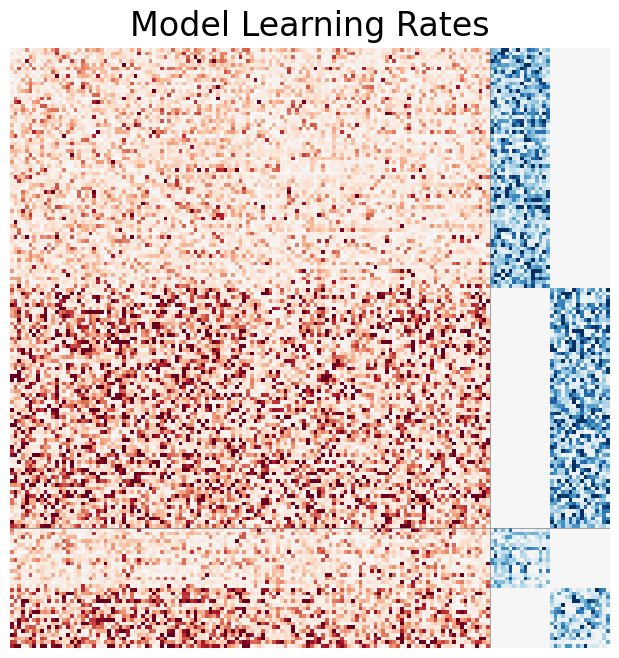

Figure saved at plots/exp/test/learning_rates.pdf


In [3]:
plot_connectivity_lr(torch.arange(args['hidden_size']*args['num_areas']), 
                             x2hw=model.rnn.x2h.effective_weight().detach(),
                             h2hw=model.rnn.h2h.effective_weight().detach(),
                             hb=state_dict['rnn.h2h.bias'].detach(),
                             h2ow=torch.cat([torch.zeros(27, E_SIZE), model.h2o.effective_weight().detach(), torch.zeros(27, I_SIZE*2)], dim=1),
                             aux2h=model.rnn.aux2h.effective_weight().detach(),
                             kappa_rec=model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

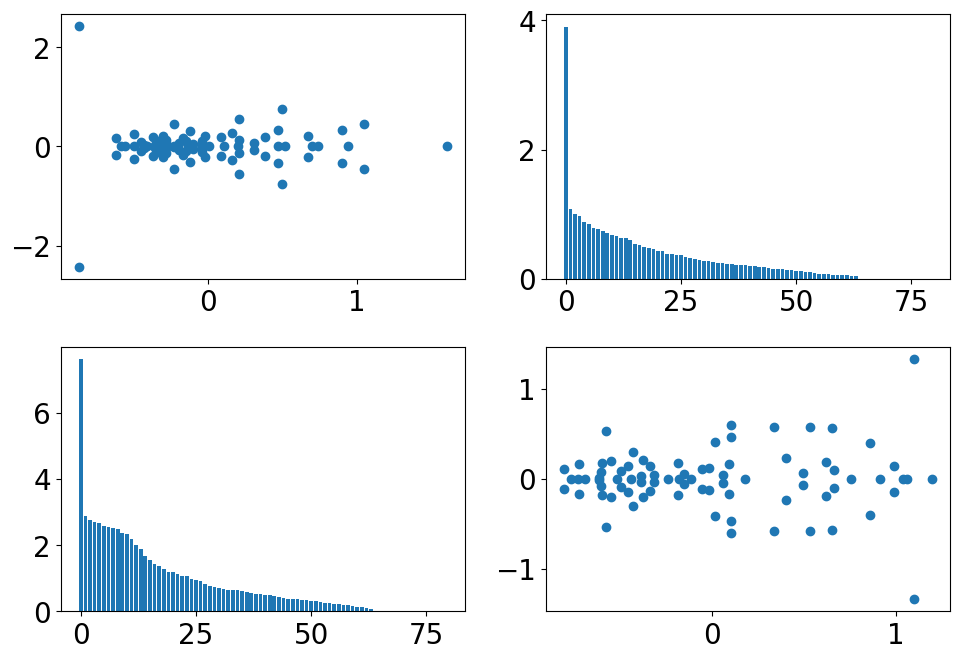

In [4]:
h2h = torch.clamp(model.rnn.h2h.effective_weight().detach(), -1, 1)

rec_intra = []
us = []
vhs = []
ss = []
for i in range(NUM_AREAS):
    rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                      [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
    u, sv, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
    s = np.linalg.eigvals(rec_intra[i])
#     us.append(u)
#     vhs.append(vh)
    ss.append(s)
    
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')


rec_inter_ff = []
rec_inter_fb = []
us_ff = []
us_fb = []
vhs_ff = []
vhs_fb = []
ss_ff = []
ss_fb = []
for i in range(NUM_AREAS-1):
   rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                         [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
   rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                         [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
   u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
   us_ff.append(u)
   vhs_ff.append(vh)
   ss_ff.append(s)
   u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
   us_fb.append(u)
   vhs_fb.append(vh)
   ss_fb.append(s)
   
    

# fig, axes = plt.subplots(NUM_AREAS, NUM_AREAS, figsize=(8, 8))
# for i in range(NUM_AREAS):
#     wlim = np.percentile(rec_intra[i].abs(), 95)
#     axes[i,i].imshow(rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r', interpolation='nearest')
#     axes[i,i].set_xticks([])
#     axes[i,i].set_yticks([])
#     axes[i,i].axis('off')

# for i in range(NUM_AREAS-1):
#     wlim = np.percentile(rec_inter_ff[i], 95)
#     axes[1,0].imshow(rec_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
#     axes[1,0].set_xticks([])
#     axes[1,0].set_yticks([])
#     axes[1,0].axis('off')
# #     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
#     wlim = np.percentile(rec_inter_fb[i], 95)
#     axes[0,1].imshow(rec_inter_fb[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
#     axes[0,1].set_xticks([])
#     axes[0,1].set_yticks([])
#     axes[0,1].axis('off')

# #     axes[i,3].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(NUM_AREAS, NUM_AREAS)

for i in range(NUM_AREAS):
    axes[i,i].scatter(ss[i].real, ss[i].imag)
#     axes[i,i].bar(np.arange(0,args['hidden_size']),ss[i])
    
for i in range(NUM_AREAS-1):
    axes[1,0].bar(np.arange(0,args['hidden_size']),ss_ff[i])
    axes[0,1].bar(np.arange(0,args['hidden_size']),ss_fb[i])

plt.tight_layout()
plt.show()

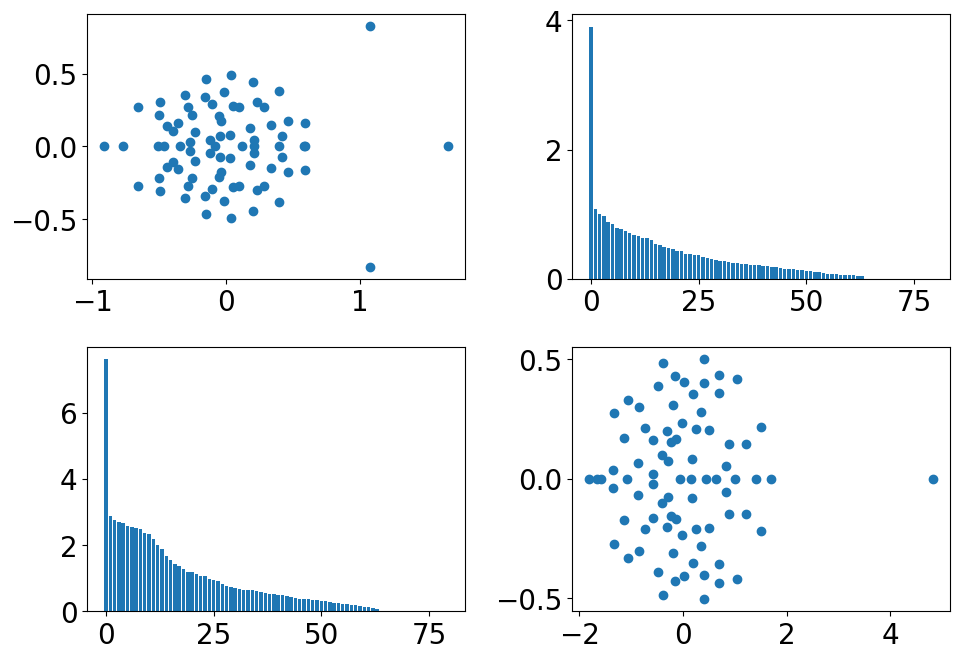

In [5]:
kappa_rec = model.rnn.kappa_rec.abs().detach()*model.rnn.h2h.mask

kappa_rec_intra = []
us = []
vhs = []
ss = []
for i in range(NUM_AREAS):
    kappa_rec_intra.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                               list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                              [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                 list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
    u, s, vh = np.linalg.svd(kappa_rec_intra[i], full_matrices=False)
    s = np.linalg.eigvals(kappa_rec_intra[i])
    us.append(u)
    vhs.append(vh)
    ss.append(s)
    
kappa_inter_ff = []
kappa_inter_fb = []
us_ff = []
us_fb = []
vhs_ff = []
vhs_fb = []
ss_ff = []
ss_fb = []
for i in range(NUM_AREAS-1):
   kappa_inter_ff.append(kappa_rec[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                 list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                             [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
   kappa_inter_fb.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                 list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                   list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
   u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
   us_ff.append(u)
   vhs_ff.append(vh)
   ss_ff.append(s)
   u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
   us_fb.append(u)
   vhs_fb.append(vh)
   ss_fb.append(s)
   

    
# fig, axes = plt.subplots(NUM_AREAS, 2)
# for i in range(NUM_AREAS):
#     wlim = np.percentile(kappa_rec_intra[i].abs(), 95)
#     axes[i,0].imshow(kappa_rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r', interpolation='nearest')
#     axes[i,1].scatter(ss[i].real, ss[i].imag)
#     axes[i,0].set_xticks([])
#     axes[i,0].set_yticks([])
#     axes[i,0].axis('off')
# #     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')

# for i in range(NUM_AREAS-1):
#     wlim = np.percentile(kappa_inter_ff[i], 95)
#     axes[0,0].imshow(kappa_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
#     axes[0,0].set_xticks([])
#     axes[0,0].set_yticks([])
#     axes[0,0].axis('off')
#     axes[0,1].bar(np.arange(1,args['hidden_size']), ss_ff[i][1:])
# #     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
#     wlim = np.percentile(kappa_inter_fb[i], 95)
#     axes[1,0].imshow(kappa_inter_fb[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
#     axes[1,0].set_xticks([])
#     axes[1,0].set_yticks([])
#     axes[1,0].axis('off')
#     axes[1,1].bar(np.arange(1,args['hidden_size']), ss_fb[i][1:])
# #     axes[i,3].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
# plt.tight_layout()
# plt.show()

fig, axes = plt.subplots(2,2)
for i in range(NUM_AREAS):
    wlim = np.percentile(kappa_rec_intra[i].abs(), 95)
    axes[i,i].scatter(ss[i].real, ss[i].imag)
    
for i in range(NUM_AREAS-1):
    axes[1,0].bar(np.arange(0,args['hidden_size']), ss_ff[i][:])
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    axes[0,1].bar(np.arange(0,args['hidden_size']), ss_fb[i][:])

plt.tight_layout()
plt.show()

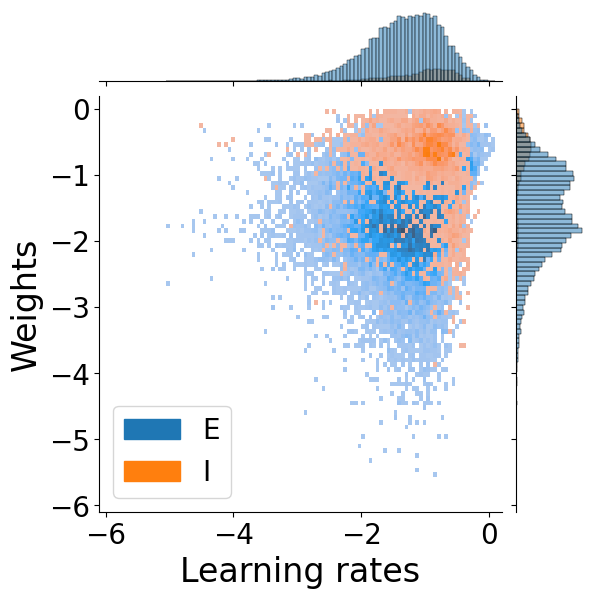

In [6]:
import seaborn as sns
import scipy.stats as stats
ei_label = np.empty(torch.sum(model.rnn.h2h.mask.squeeze().flatten().abs()>0).long().item(), dtype=object)
ei_label[model.rnn.h2h.mask.squeeze().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]>0] = 'E'
ei_label[model.rnn.h2h.mask.squeeze().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]<0] = 'I'
sjp = sns.jointplot(x=np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    y=np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    hue=ei_label, kind='hist')
sjp.set_axis_labels('Learning rates', 'Weights', fontsize=24)
sns.move_legend(sjp.ax_joint, 'lower left')
plt.xlim([-6.1, 0.2])
plt.ylim([-6.1, 0.2])
plt.show()

# a, b = np.polyfit(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                   np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), 1)
# plt.plot(np.linspace(-4, 0, 100), a*np.linspace(-4, 0, 100)+b, c='k')
# stats.spearmanr(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                 np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]))

# Subspace Analysis


### Decompose each input, output, and choice pattern as a sum of feature, conjunction, and object patterns
$I_{i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [9]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))
output_weight_inds = list(range(E_SIZE, 2*E_SIZE)) + list(range(E_SIZE*args['num_areas']+I_SIZE, E_SIZE*args['num_areas']+2*I_SIZE))

stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
    model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
    task_mdprl.stim_encoding('all_onehot'))

# global_avg_out, ft_avg_out, conj_avg_out, obj_avg_out = get_input_encodings(
#     model.h2o.effective_weight().detach().numpy().T, np.eye(27))

## Use dPCA to get ft/conj/obj specific axes in the input and output weights

In [10]:
n_components_for_dpca = {'s':2, 'p':2, 'c':2, 'sc':4, 'sp':4, 'pc':4, 'spc': 8}

dpca_in = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_input = dpca_in.fit_transform(stims.reshape((args['hidden_size'],3,3,3)))

expanded_h2o = torch.cat([model.h2o.effective_weight().detach(), torch.zeros(27, I_SIZE)], dim=1)
dpca_out = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_output = dpca_out.fit_transform(expanded_h2o.numpy().T.reshape((args['hidden_size'],3,3,3)))

dpca_ch = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_ch = dpca_ch.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy()[list(range(E_SIZE, E_SIZE*2))+list(range(E_SIZE*2+I_SIZE, E_SIZE*2+I_SIZE*2)),:].reshape((args['hidden_size'],3,3,3)))

dpca_stim = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
low_stims = dpca_stim.fit_transform(task_mdprl.stim_encoding('all_onehot').T.reshape((63,3,3,3)))


/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]


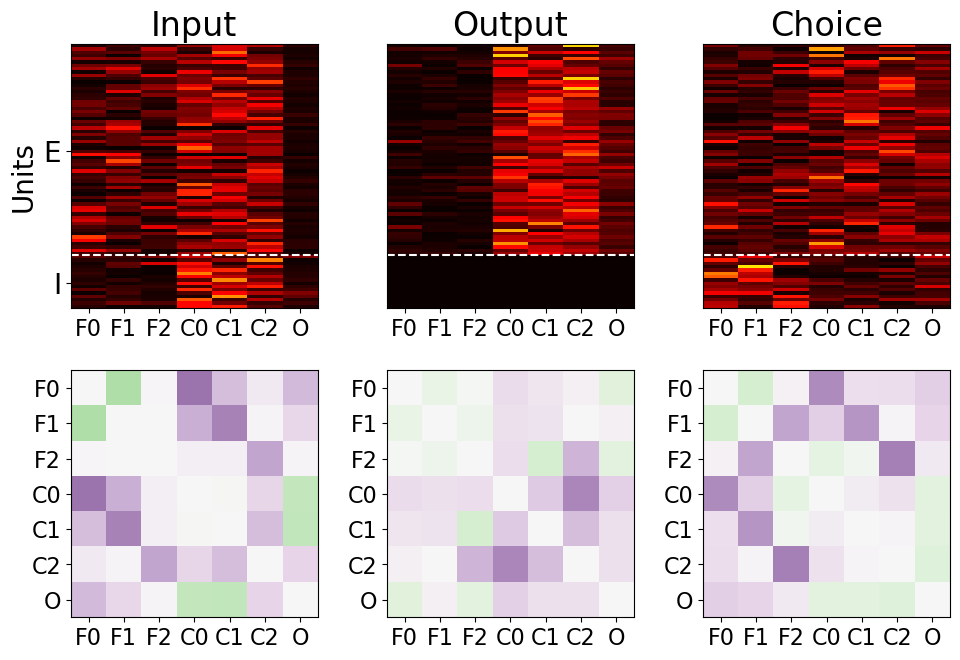

In [11]:
fig, axes = plt.subplots(2,3, height_ratios=(1,1))

corr_scale = 1

unitwise_selectivity_input = np.zeros((7, args['hidden_size']))
for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
    unitwise_selectivity_input[k_idx] = np.sum(dpca_in.unitwise_explained_variance_ratio_[k], 0)
axes[0,0].imshow(unitwise_selectivity_input.T, aspect='auto', cmap='hot', vmin=0, vmax=1)
axes[1,0].imshow(spearmanr(unitwise_selectivity_input.T).correlation-np.eye(7), cmap='PRGn', vmin=-corr_scale, vmax=corr_scale)
axes[0,0].set_title('Input')

unitwise_selectivity_output = np.zeros((7, args['hidden_size']))
for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
    unitwise_selectivity_output[k_idx] = np.sum(dpca_out.unitwise_explained_variance_ratio_[k], 0)
    unitwise_selectivity_output[unitwise_selectivity_output>1]=np.nan
axes[0,1].imshow(np.nan_to_num(unitwise_selectivity_output.T, 0), aspect='auto', cmap='hot', vmin=0, vmax=1)
axes[1,1].imshow(spearmanr(unitwise_selectivity_output[:,:E_SIZE].T).correlation-np.eye(7), cmap='PRGn', vmin=-corr_scale, vmax=corr_scale)
axes[0,1].set_title('Output')

unitwise_selectivity_choice = np.zeros((7, args['hidden_size']))
for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
    unitwise_selectivity_choice[k_idx] = np.sum(dpca_ch.unitwise_explained_variance_ratio_[k], 0)
axes[0,2].imshow(unitwise_selectivity_choice.T, aspect='auto', cmap='hot', vmin=0, vmax=1)
axes[1,2].imshow(spearmanr(unitwise_selectivity_choice.T).correlation-np.eye(7), cmap='PRGn', vmin=-corr_scale, vmax=corr_scale)
axes[0,2].set_title('Choice')


axes[0,0].set_yticks([32, 72], ['E', 'I'])
axes[0,0].set_ylabel('Units')

for i in range(3):
    if i>0:
        axes[0,i].set_yticks([])
    axes[0,i].axhline(E_SIZE-0.5, color='white', linestyle='--')
    axes[0,i].set_xticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[1,i].set_xticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[1,i].set_yticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)

plt.tight_layout()


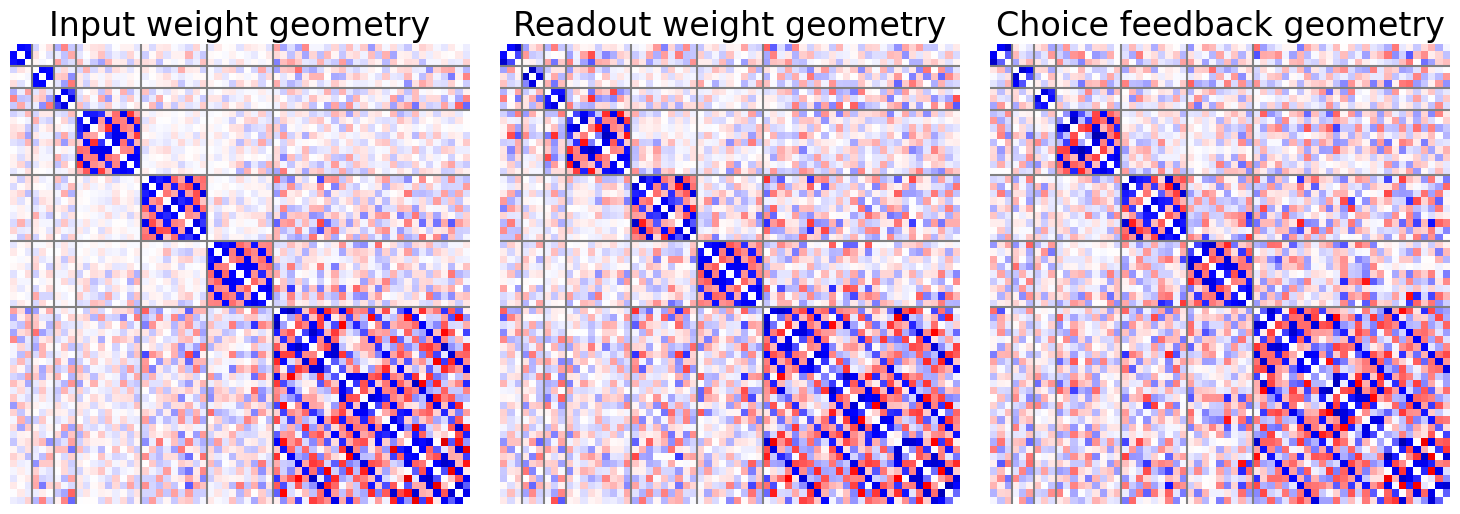

In [12]:
all_dpca_psth_in = np.concatenate([dpca_in.marginalized_psth['s'].squeeze(), 
                                   dpca_in.marginalized_psth['p'].squeeze(), 
                                   dpca_in.marginalized_psth['c'].squeeze(), 
                                   dpca_in.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_in.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_in.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_in.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                   axis=1)

all_dpca_psth_out = np.concatenate([dpca_out.marginalized_psth['s'].squeeze(), 
                                   dpca_out.marginalized_psth['p'].squeeze(), 
                                   dpca_out.marginalized_psth['c'].squeeze(), 
                                   dpca_out.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_out.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_out.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_out.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                   axis=1)

all_dpca_psth_ch = np.concatenate([dpca_ch.marginalized_psth['s'].squeeze(), 
                                   dpca_ch.marginalized_psth['p'].squeeze(), 
                                   dpca_ch.marginalized_psth['c'].squeeze(), 
                                   dpca_ch.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_ch.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_ch.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                   dpca_ch.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                   axis=1)


fig, axes = plt.subplots(1,3)
fig.set_size_inches((15, 8))
axes[0].imshow(batch_cosine_similarity(all_dpca_psth_in.T, all_dpca_psth_in.T)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[0].set_title("Input weight geometry")
axes[1].imshow(batch_cosine_similarity(all_dpca_psth_out.T, all_dpca_psth_out.T)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title("Readout weight geometry")
axes[2].imshow(batch_cosine_similarity(all_dpca_psth_ch.T, all_dpca_psth_ch.T)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[2].set_title("Choice feedback geometry")

block_boundaries = [2.5, 5.5, 8.5, 17.5, 26.5, 35.5]
for i in range(3):
    axes[i].axis('off')
    for bb in block_boundaries:
        axes[i].axvline(x=bb,color='grey')
        axes[i].axhline(y=bb,color='grey')
    
plt.tight_layout()
plt.show()


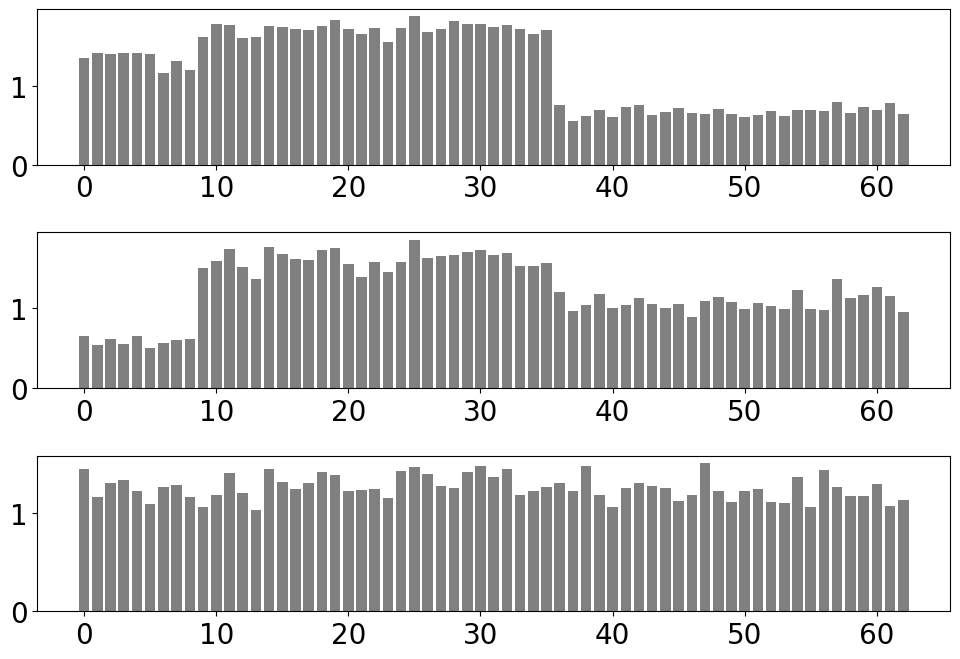

In [13]:
fig, axes = plt.subplots(3,1)

axes[0].bar(np.arange(63), np.linalg.norm(all_dpca_psth_in, axis=0), color='grey')
axes[1].bar(np.arange(63), np.linalg.norm(all_dpca_psth_out, axis=0), color='grey')
axes[2].bar(np.arange(63), np.linalg.norm(all_dpca_psth_ch, axis=0), color='grey')
plt.tight_layout()

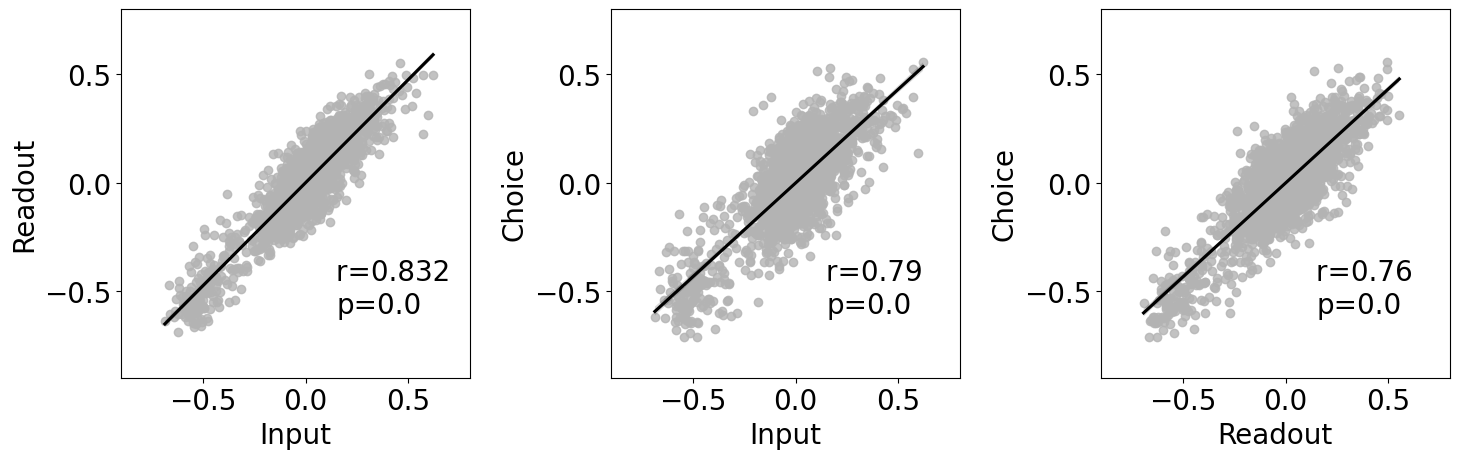

In [14]:
triu_inds = np.triu_indices(63, k = 1)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((15, 5))

all_dpca_psth_stim = np.concatenate([dpca_stim.marginalized_psth['s'].squeeze(), 
                                     dpca_stim.marginalized_psth['p'].squeeze(), 
                                     dpca_stim.marginalized_psth['c'].squeeze(), 
                                     dpca_stim.marginalized_psth['pc'].squeeze().reshape((63, 9)), 
                                     dpca_stim.marginalized_psth['sc'].squeeze().reshape((63, 9)), 
                                     dpca_stim.marginalized_psth['sp'].squeeze().reshape((63, 9)), 
                                     dpca_stim.marginalized_psth['spc'].squeeze().reshape((63, 27))], 
                                   axis=1)

dpca_in_rdm = batch_cosine_similarity(all_dpca_psth_in.T, all_dpca_psth_in.T)[triu_inds]
dpca_out_rdm = batch_cosine_similarity(all_dpca_psth_out.T, all_dpca_psth_out.T)[triu_inds]
dpca_ch_rdm = batch_cosine_similarity(all_dpca_psth_ch.T, all_dpca_psth_ch.T)[triu_inds]
dpca_stim_rdm = batch_cosine_similarity(all_dpca_psth_stim.T, all_dpca_psth_stim.T)[triu_inds]

sns.regplot(x=dpca_in_rdm, y=dpca_out_rdm,  ax=axes[0], 
            scatter_kws={"color":[0.7, 0.7, 0.7, 0.2]},
            line_kws={"color":[0,0,0,1]})
temp_corr = pearsonr(dpca_in_rdm, dpca_stim_rdm)
axes[0].text(0.15, -0.6, f"r={np.round(temp_corr.correlation, 3)} \np={np.round(temp_corr.pvalue, 4)}")
axes[0].set_xlabel("Input")
axes[0].set_ylabel("Readout")
sns.regplot(x=dpca_in_rdm, y=dpca_ch_rdm,  ax=axes[1], 
            scatter_kws={"color":[0.7, 0.7, 0.7, 0.2]},
            line_kws={"color":[0,0,0,1]})
temp_corr = pearsonr(dpca_out_rdm, dpca_stim_rdm)
axes[1].text(0.15, -0.6, f"r={np.round(temp_corr.correlation, 3)} \np={np.round(temp_corr.pvalue, 4)}")
axes[1].set_xlabel("Input")
axes[1].set_ylabel("Choice")
sns.regplot(x=dpca_out_rdm, y=dpca_ch_rdm,  ax=axes[2], 
            scatter_kws={"color":[0.7, 0.7, 0.7, 0.2]},
            line_kws={"color":[0,0,0,1]})
temp_corr = pearsonr(dpca_ch_rdm, dpca_stim_rdm)
axes[2].set_xlabel("Readout")
axes[2].set_ylabel("Choice")
axes[2].text(0.15, -0.6, f"r={np.round(temp_corr.correlation, 3)} \np={np.round(temp_corr.pvalue, 4)}")

for i in range(3):
    axes[i].set_xlim([-0.9, 0.8])
    axes[i].set_ylim([-0.9, 0.8])
plt.tight_layout()
plt.show()

0.13070555525419725 0.03621739149093628 0.15130317211151123
0.13427520887659805 0.03201264142990112 0.13053059577941895
0.10195609078807855 0.03494572639465332 0.13455575704574585
0.1956077277939301 0.25425630807876587 0.13801002502441406
0.2019036962829055 0.2600927948951721 0.15639477968215942
0.20458120363146648 0.2658863067626953 0.1552356481552124
0.030970517372821305 0.11658889055252075 0.1339685320854187
Figure saved at plots/exp/test/input_output_weight_variance.pdf


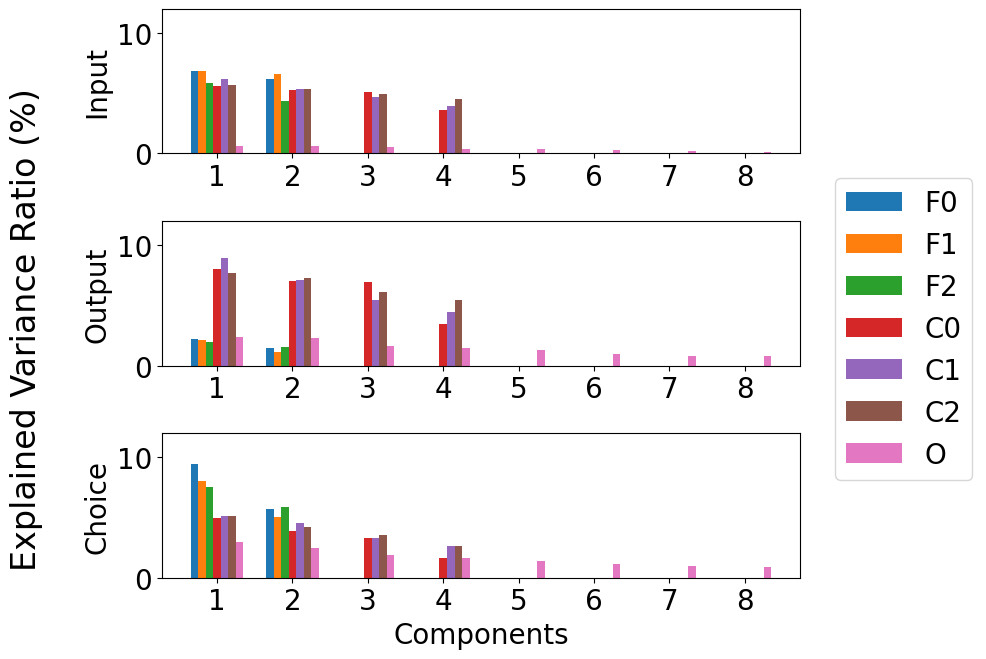

In [15]:
fig, axes = plt.subplots(3,1)

bar_width = 0.1
labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']

key_plot_order = ['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']

for k_idx, k in enumerate(key_plot_order):
    bar_x = np.arange(len(dpca_in.explained_variance_ratio_[k]))
    print(np.sum(dpca_in.explained_variance_ratio_[k]), \
          np.sum(dpca_out.explained_variance_ratio_[k]), \
          np.sum(dpca_ch.explained_variance_ratio_[k]))
    axes[0].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_in.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])
    axes[1].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_out.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])
    axes[2].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_ch.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])

axes[2].set_xlabel('Components')
axes[0].set_xticks(np.arange(0,8,1))
axes[1].set_xticks(np.arange(0,8,1))
axes[2].set_xticks(np.arange(0,8,1))
axes[0].set_xticklabels(np.arange(1,9,1))
axes[1].set_xticklabels(np.arange(1,9,1))
axes[2].set_xticklabels(np.arange(1,9,1))
axes[0].set_ylim([-0.0, 12])
axes[1].set_ylim([-0.0, 12])
axes[2].set_ylim([-0.0, 12])
axes[0].set_ylabel("Input")
axes[1].set_ylabel("Output")
axes[2].set_ylabel("Choice")
fig.supylabel('Explained Variance Ratio (%)')
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
box = axes[0].get_position()
# axes[0].text(5, 8, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_in.explained_variance_ratio_.values()]))}%')
axes[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[1].get_position()
# axes[1].text(5, 8, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_out.explained_variance_ratio_.values()]))}%')
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[2].get_position()
# axes[2].text(5, 8, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_ch.explained_variance_ratio_.values()]))}%')
axes[2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
fig.legend(handles, labels, loc='center right')
fig.show()

with PdfPages(f'plots/{args["exp_dir"]}/input_output_weight_variance.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/input_output_weight_variance.pdf')


[0.38636625 0.99672388 0.99672388 0.99672388 0.99672388]
[0.20060695 0.25160277 0.25160277 0.25160277 0.25160277]
[0.00331529 0.2224269  0.2224269  0.2224269  0.2224269 ]
Figure saved at plots/exp/test/fixed_weight_axis_overlap.pdf


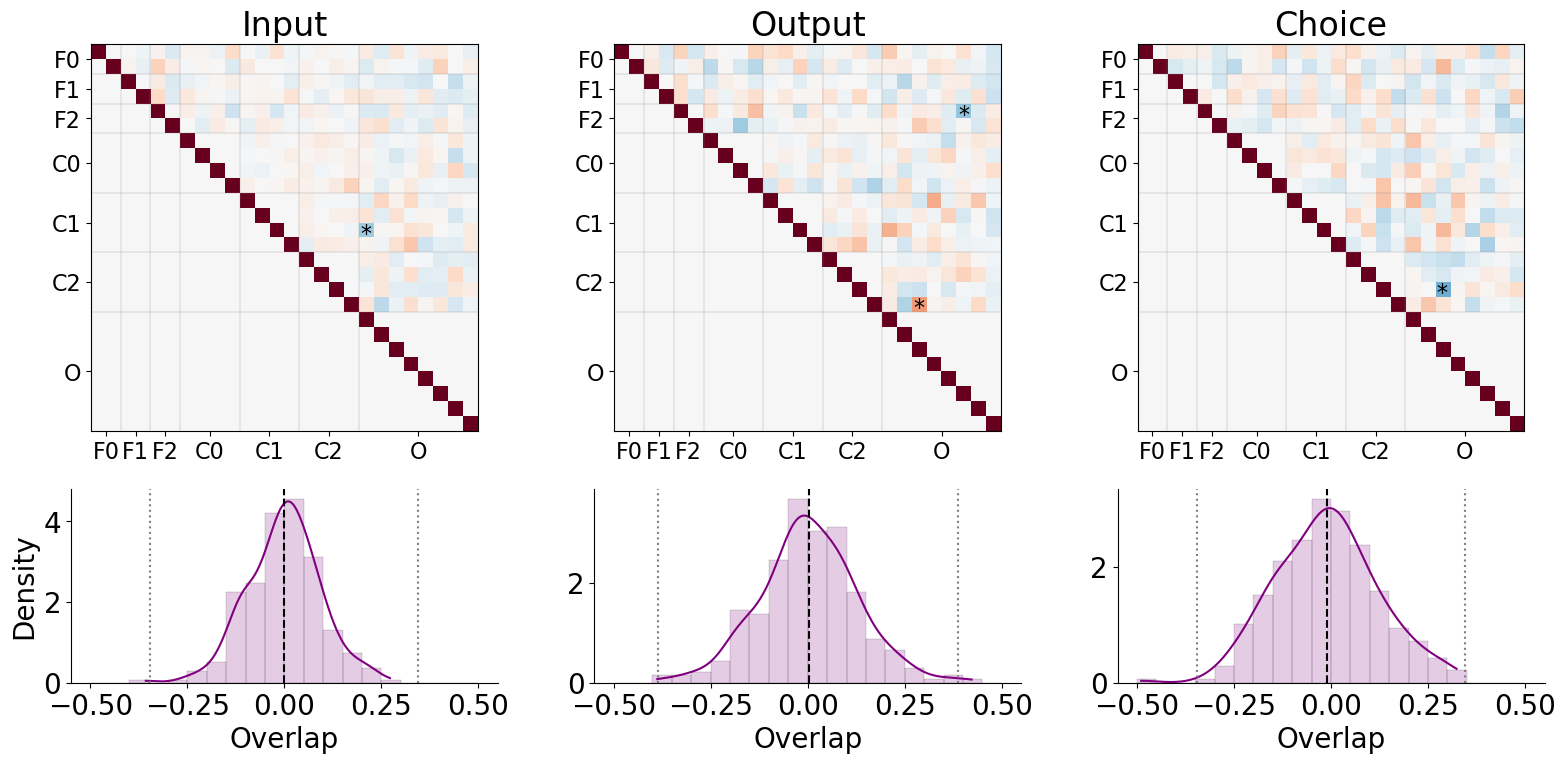

In [16]:
from statsmodels.stats.multitest import fdrcorrection

def test_dpca_overlap(dpca_result, keys, low_hs, overlap_scale, label, axes):
    all_dpca_axes = np.concatenate([dpca_result.P[k] for k in keys], axis=1) # concat all axes
    all_dpca_low_hs = np.concatenate([low_hs[k].reshape((low_hs[k].shape[0],-1)) 
                                      for k in keys], axis=0) # concat all axes
    low_hs_corr_val = np.corrcoef(all_dpca_low_hs)
    axes_overlap = all_dpca_axes.T@all_dpca_axes # dot product similarity
    axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0) # rank correlation similarity
    all_overlaps = []
    all_pvals = []
    sig_thresh = np.abs(norm.ppf(0.001))*overlap_scale
    for k_idx1 in range(len(keys)):
        for k_idx2 in range(k_idx1+1, len(keys)):
            pair_overlaps = (dpca_result.P[keys[k_idx1]].T@dpca_result.P[keys[k_idx2]]).flatten()
            all_overlaps.append(pair_overlaps)
            all_pvals.append(norm.cdf(-np.abs(pair_overlaps), loc=0, scale=overlap_scale)+ \
                norm.sf(np.abs(pair_overlaps), loc=0, scale=overlap_scale))
    all_overlaps = np.concatenate(all_overlaps)
    all_pvals = np.concatenate(all_pvals)
    _, all_corrected_pvals = fdrcorrection(all_pvals)
    
    
    tril_mask = np.zeros_like(axes_overlap)
    tril_mask[np.tril_indices(axes_overlap.shape[0], k=-1)] = 1
    
    triu_mask = np.zeros_like(axes_overlap)
    triu_mask[np.triu_indices(axes_overlap.shape[0], k=0)] = 1
    
    # plot overlap values
    axes[0].imshow(axes_overlap*triu_mask+low_hs_corr_val*tril_mask, cmap='RdBu_r', vmin=-1, vmax=1)
    
    txs, tys = np.meshgrid(np.arange(axes_overlap.shape[0]),np.arange(axes_overlap.shape[0]))
    txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
    tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
    
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
    for i in block_boundaries:
        axes[0].axvline(x=i,color='grey',linewidth=0.2)
        axes[0].axhline(y=i,color='grey',linewidth=0.2)
        
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2-0.5

    axes[0].set_xticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[0].set_yticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    
    for (x,y) in zip(txs, tys):
        if x<=y:
            continue
        else:
            axes[0].text(x-0.4, y+0.7, '*', {'size': 16})
    
    sns.histplot(x=all_overlaps, color='purple',ax=axes[1], stat='density', 
                 kde=True, bins=np.linspace(-0.5,0.5,21), linewidth=0.1, alpha=0.2)
    axes[1].set_xlabel('Overlap')
    axes[1].axvline(sig_thresh, color='grey', linestyle=':')
    axes[1].axvline(all_overlaps.mean(), color='black', linestyle='--')
    axes[1].axvline(-sig_thresh, color='grey', linestyle=':')
    
    
    axes[0].set_title(label, fontsize=24)
    
    axes[1].spines[['right', 'top']].set_visible(False)
    
    return all_overlaps, all_corrected_pvals, all_dpca_axes
    
    
fig, axes = plt.subplots(2, 3, height_ratios=(2, 1), figsize=(16, 8))
    
dpca_in_overlaps, dpca_in_overlap_pvals, all_dpca_axes_in = \
            test_dpca_overlap(dpca_in, ['s','p','c','pc','sc','sp','spc'], 
                              low_input, 1/np.sqrt(args['hidden_size']), 
                              "Input", axes[:,0])
dpca_out_overlaps, dpca_out_overlap_pvals, all_dpca_axes_out = \
            test_dpca_overlap(dpca_out, ['s','p','c','pc','sc','sp','spc'], 
                              low_output, 1/np.sqrt(int(args['hidden_size']*args['e_prop'])), 
                              "Output", axes[:,1])
dpca_ch_overlaps, dpca_ch_overlap_pvals, all_dpca_axes_ch = \
            test_dpca_overlap(dpca_ch, ['s','p','c','pc','sc','sp','spc'], 
                              low_ch, 1/np.sqrt(args['hidden_size']), 
                              "Choice", axes[:,2])
axes[1,1].set_ylabel(" ")
axes[1,2].set_ylabel(" ")

print(np.sort(dpca_in_overlap_pvals)[:5])
print(np.sort(dpca_out_overlap_pvals)[:5])
print(np.sort(dpca_ch_overlap_pvals)[:5])
num_comparisons = dpca_in_overlap_pvals.shape[0]
# ax = sns.violinplot(x=["Input"]*num_comparisons+["Output"]*num_comparisons+["Choice"]*num_comparisons,
#                y=np.concatenate([dpca_in_overlaps, dpca_out_overlaps, dpca_ch_overlaps]),
#                 palette=sns.color_palette('pastel'))
# ax.set_ylabel('Axis overlap')
# ax.axhline(np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size'])), color='k', linestyle='--')
# ax.axhline(-np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size'])), color='k', linestyle='--')

plt.tight_layout()

with PdfPages(f'plots/{args["exp_dir"]}/fixed_weight_axis_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/fixed_weight_axis_overlap.pdf')

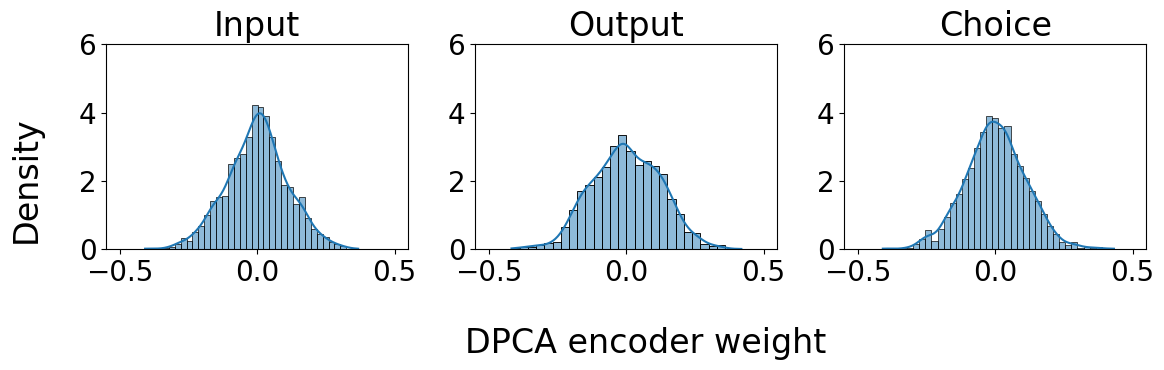

In [17]:
fig, axes = plt.subplots(1,3,figsize=(12, 4))

sns.histplot(x=all_dpca_axes_in.flatten(), stat='density', kde=True, ax=axes[0])
axes[0].set_title('Input')
sns.histplot(x=all_dpca_axes_out[:64].flatten(), stat='density', kde=True, ax=axes[1])
axes[1].set_title('Output')
sns.histplot(x=all_dpca_axes_ch.flatten(), stat='density', kde=True, ax=axes[2])
axes[2].set_title('Choice')

fig.supxlabel('DPCA encoder weight', y=0.05, x=0.55)
fig.supylabel('Density')

for i in range(3):
    axes[i].set_ylabel("")
    axes[i].set_xlim([-0.55, 0.55])
    axes[i].set_ylim([0, 6])

plt.tight_layout()

# Analysis of Naive Weights of RNN

MannwhitneyuResult(statistic=17438.0, pvalue=8.047106496631723e-20)
MannwhitneyuResult(statistic=17469.0, pvalue=5.951664742485087e-20)
MannwhitneyuResult(statistic=17484.0, pvalue=5.141458042051143e-20)
Figure saved at plots/exp/test/recurrent_transform_overlap.pdf


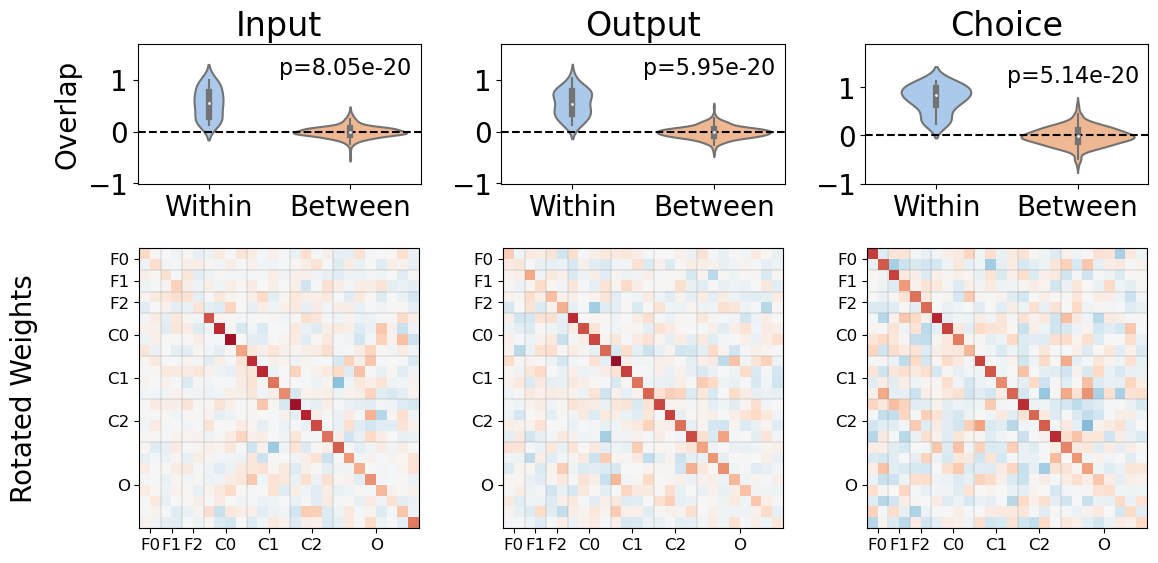

In [18]:
# plt.imshow(all_dpca_axes.T@rec_intra[1].detach().numpy()@all_dpca_axes, vmin=-1, vmax=1, cmap='seismic')

fig, axes = plt.subplots(2,3, figsize=(12, 6), height_ratios=[1, 2])


num_components = all_dpca_axes_in.shape[1]

input_rec_overlap = all_dpca_axes_in.T@rec_intra[0].detach().numpy()@all_dpca_axes_in
axes[1,0].imshow(input_rec_overlap, vmin=-1.2, vmax=1.2, cmap='RdBu_r')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
sns.violinplot(ax=axes[0,0], 
            x=['Within']*num_components+['Between']*(num_components*(num_components-1)//2),
            y=np.concatenate([np.diag(input_rec_overlap), input_rec_overlap[np.triu_indices(num_components, k=1)]]),
            palette=sns.color_palette("pastel"))
temp_stats = stats.mannwhitneyu(
    np.diag(all_dpca_axes_in.T@rec_intra[0].detach().numpy()@all_dpca_axes_in), 
    np.triu(all_dpca_axes_in.T@rec_intra[0].detach().numpy()@all_dpca_axes_in, 1).flatten())
axes[0,0].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
axes[0,0].axhline(0, linestyle='--', color='k')
axes[0,0].set_ylim([-1.01, 1.7])
axes[0,0].set_ylabel("")
axes[0,0].set_title("Input")
print(temp_stats)

output_rec_overlap = all_dpca_axes_out.T@rec_intra[1].detach().numpy()@all_dpca_axes_out
axes[1,1].imshow(output_rec_overlap, vmin=-1.2, vmax=1.2, cmap='RdBu_r')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
sns.violinplot(ax=axes[0,1], 
            x=['Within']*num_components+['Between']*(num_components*(num_components-1)//2),
            y=np.concatenate([np.diag(output_rec_overlap), output_rec_overlap[np.triu_indices(num_components, k=1)]]),
            palette=sns.color_palette("pastel"))

temp_stats = stats.mannwhitneyu(
    np.diag(all_dpca_axes_out.T@rec_intra[1].detach().numpy()@all_dpca_axes_out),
    np.triu(all_dpca_axes_out.T@rec_intra[1].detach().numpy()@all_dpca_axes_out, 1).flatten())
axes[0,1].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
axes[0,1].axhline(0, linestyle='--', color='k')
axes[0,1].set_ylim([-1.01, 1.7])
axes[0,1].set_ylabel("")
axes[0,1].set_title("Output")
print(temp_stats)

choice_rec_overlap = all_dpca_axes_ch.T@rec_intra[1].detach().numpy()@all_dpca_axes_ch
axes[1,2].imshow(choice_rec_overlap, vmin=-1.5, vmax=1.5, cmap='RdBu_r')
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])
sns.violinplot(ax=axes[0,2], 
            x=['Within']*num_components+['Between']*(num_components*(num_components-1)//2),
            y=np.concatenate([np.diag(choice_rec_overlap), choice_rec_overlap[np.triu_indices(num_components, k=1)]]),
            palette=sns.color_palette("pastel"))
temp_stats = stats.mannwhitneyu(
    np.diag(all_dpca_axes_ch.T@rec_intra[1].detach().numpy()@all_dpca_axes_ch),
    np.triu(all_dpca_axes_ch.T@rec_intra[1].detach().numpy()@all_dpca_axes_ch, 1).flatten())
axes[0,2].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
axes[0,2].axhline(0, linestyle='--', color='k')
axes[0,2].set_ylim([-1.01, 1.9])
axes[0,2].set_ylabel("")
axes[0,2].set_title("Choice")
print(temp_stats)

axes[0,0].set_ylabel('Overlap')
axes[1,0].set_ylabel('Rotated Weights', labelpad=50)

for j in range(3):
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
    for i in block_boundaries:
        axes[1,j].axvline(x=i,color='grey',linewidth=0.2)
        axes[1,j].axhline(y=i,color='grey',linewidth=0.2)
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2-0.5
    axes[1,j].set_xticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=12)
    axes[1,j].set_yticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=12)

fig.tight_layout()

with PdfPages(f'plots/{args["exp_dir"]}/recurrent_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/recurrent_transform_overlap.pdf')


Figure saved at plots/exp/test/interareal_transform_overlap.pdf


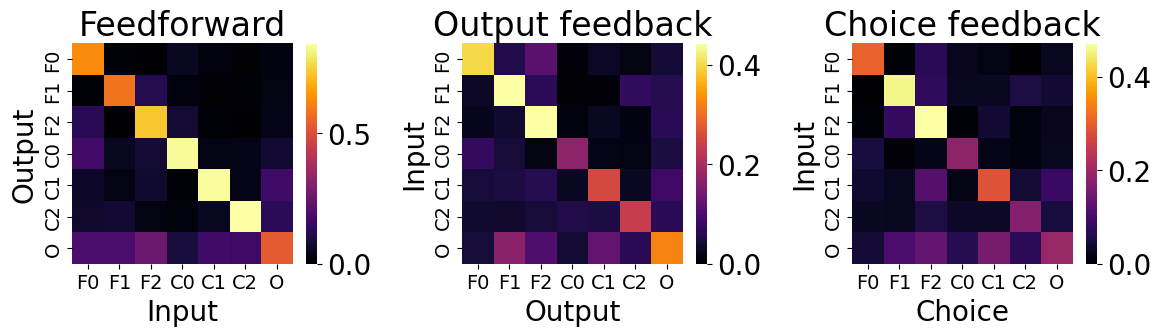

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))

explained_vars = np.zeros((7,7))

for k_in_idx, k_in in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
    ff_currents = rec_inter_ff[0].detach().numpy()@dpca_in.P[k_in]
    ff_currents = ff_currents-ff_currents.mean(1, keepdims=True)
    for k_out_idx, k_out in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
        explained_vars[k_out_idx][k_in_idx] = 1-(np.sum((ff_currents-dpca_out.P[k_out]@dpca_out.P[k_out].T@ff_currents)**2))/np.sum(ff_currents**2)
        
cm = sns.heatmap(explained_vars, ax=axes[0], vmin=0, vmax=None, cmap='inferno', 
                 square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 0.5})
# fig.colorbar(cm,fraction=0.046, pad=0.04)
axes[0].set_title('Feedforward')
axes[0].set_ylabel('Output')
axes[0].set_xlabel('Input')
        
explained_vars = np.zeros((7,7))

for k_in_idx, k_in in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
    fb_currents = rec_inter_fb[0].detach().numpy()@dpca_out.P[k_in]
    fb_currents = fb_currents-fb_currents.mean(1, keepdims=True)
    for k_out_idx, k_out in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
        explained_vars[k_out_idx][k_in_idx] = 1-(np.sum((fb_currents-dpca_in.P[k_out]@dpca_in.P[k_out].T@fb_currents)**2))/np.sum(fb_currents**2)
        
cm = sns.heatmap(explained_vars, ax=axes[1], vmin=0, vmax=None, cmap='inferno', 
                 square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 0.5})
# fig.colorbar(cm,fraction=0.046, pad=0.04)
axes[1].set_title('Output feedback')
axes[1].set_ylabel('Input')
axes[1].set_xlabel('Output')


for k_in_idx, k_in in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
    fb_currents = rec_inter_fb[0].detach().numpy()@dpca_ch.P[k_in]
    fb_currents = fb_currents-fb_currents.mean(1, keepdims=True)
    for k_out_idx, k_out in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
        explained_vars[k_out_idx][k_in_idx] = 1-(np.sum((fb_currents-dpca_in.P[k_out]@dpca_in.P[k_out].T@fb_currents)**2))/np.sum(fb_currents**2)
        
cm = sns.heatmap(explained_vars, ax=axes[2], vmin=0, vmax=None, cmap='inferno', 
                 square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 0.5})
# fig.colorbar(cm,fraction=0.046, pad=0.04)
axes[2].set_title('Choice feedback')
axes[2].set_ylabel('Input')
axes[2].set_xlabel('Choice')

for i in range(3):
    axes[i].set_xticks(np.arange(0,7)+0.5)
    axes[i].set_xticklabels(["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=14)
    axes[i].set_yticks(np.arange(0,7)+0.5)
    axes[i].set_yticklabels(["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=14)

fig.tight_layout()

with PdfPages(f'plots/{args["exp_dir"]}/interareal_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/interareal_transform_overlap.pdf')


# Analysis of learning rate matrix of the recurrent weights

Figure saved at plots/exp/test/hebbian_learning_overlap.pdf


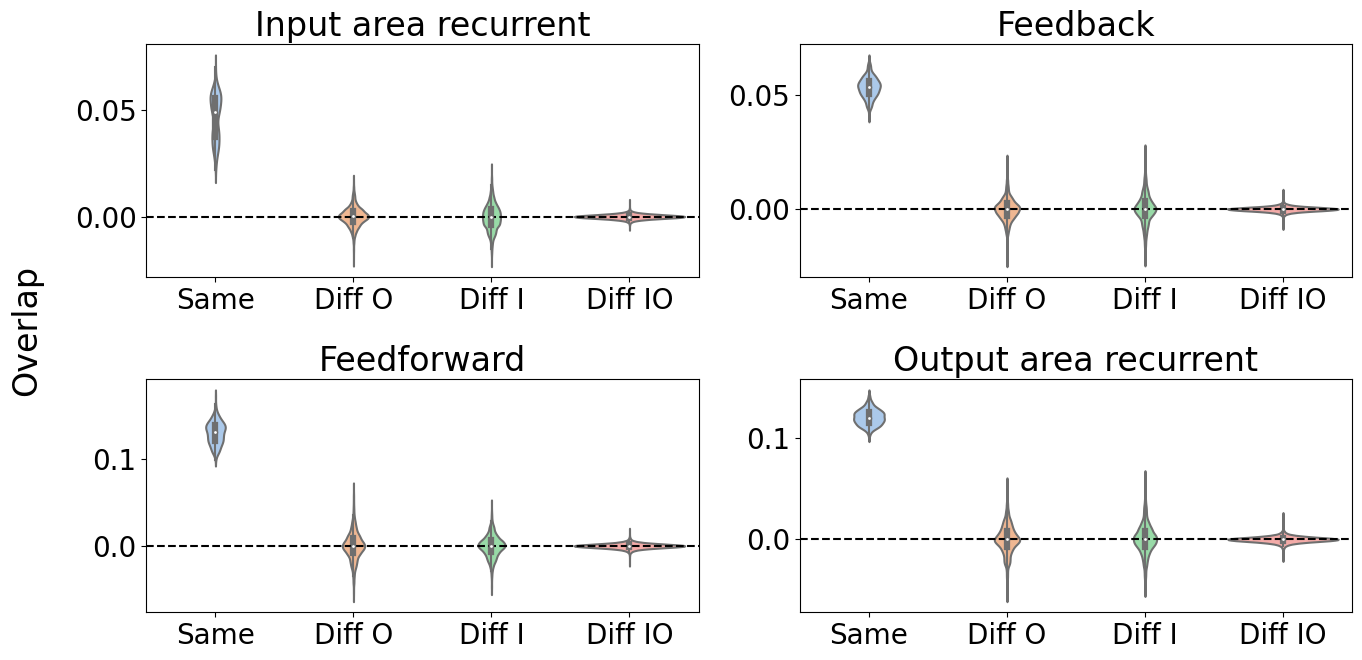

In [20]:
fig, axes = plt.subplots(2,2, figsize=(14, 7))

# recurrent plasticity in input area
overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}

for i in range(all_dpca_axes_in.shape[1]):
    for j in range(all_dpca_axes_in.shape[1]):
        mem_mat = kappa_rec_intra[0].numpy()*(all_dpca_axes_in[:,i:i+1]@all_dpca_axes_in[:,j:j+1].T)
        for k in range(all_dpca_axes_in.shape[1]):
            for l in range(all_dpca_axes_in.shape[1]):
                curr_overlap = all_dpca_axes_in[:,l:l+1].T@mem_mat@all_dpca_axes_in[:,k:k+1]
                if i==l and j==k:
                    overlaps['same_pre_post'].append(curr_overlap)
                elif j==k:
                    overlaps['same_pre'].append(curr_overlap)
                elif i==l:
                    overlaps['same_post'].append(curr_overlap)
                else:
                    overlaps['diff'].append(curr_overlap)

sns.violinplot(ax=axes[0,0],
              x=['Same']*num_components**2+\
               ['Diff O']*(num_components-1)*num_components**2+
               ['Diff I']*(num_components-1)*num_components**2+\
               ['Diff IO']*num_components**2*(num_components-1)**2,
              y=np.concatenate([np.array(overlaps['same_pre_post']).squeeze(),
                               np.array(overlaps['same_pre']).squeeze(),
                               np.array(overlaps['same_post']).squeeze(),
                               np.array(overlaps['diff']).squeeze()]),
              palette=sns.color_palette('pastel'))
axes[0,0].axhline(0, linestyle = '--', color='k')
axes[0,0].set_title('Input area recurrent')

# recurrent plasticity in output area
overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}

for i in range(all_dpca_axes_in.shape[1]):
    for j in range(all_dpca_axes_in.shape[1]):
        mem_mat = kappa_rec_intra[1].numpy()*(all_dpca_axes_out[:,i:i+1]@all_dpca_axes_out[:,j:j+1].T)
        for k in range(all_dpca_axes_in.shape[1]):
            for l in range(all_dpca_axes_in.shape[1]):
                curr_overlap = all_dpca_axes_out[:,l:l+1].T@mem_mat@all_dpca_axes_out[:,k:k+1]
                if i==l and j==k:
                    overlaps['same_pre_post'].append(curr_overlap)
                elif j==k:
                    overlaps['same_pre'].append(curr_overlap)
                elif i==l:
                    overlaps['same_post'].append(curr_overlap)
                else:
                    overlaps['diff'].append(curr_overlap)
                    
sns.violinplot(ax=axes[1,1],
              x=['Same']*num_components**2+\
               ['Diff O']*(num_components-1)*num_components**2+
               ['Diff I']*(num_components-1)*num_components**2+\
               ['Diff IO']*num_components**2*(num_components-1)**2,
              y=np.concatenate([np.array(overlaps['same_pre_post']).squeeze(),
                               np.array(overlaps['same_pre']).squeeze(),
                               np.array(overlaps['same_post']).squeeze(),
                               np.array(overlaps['diff']).squeeze()]),
              palette=sns.color_palette('pastel'))
axes[1,1].axhline(0, linestyle = '--', color='k')
axes[1,1].set_title('Output area recurrent')


# feedforward plasticity
overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}

for i in range(all_dpca_axes_in.shape[1]):
    for j in range(all_dpca_axes_in.shape[1]):
        mem_mat = kappa_inter_ff[0].numpy()*(all_dpca_axes_out[:,i:i+1]@all_dpca_axes_in[:,j:j+1].T)
        for k in range(all_dpca_axes_in.shape[1]):
            for l in range(all_dpca_axes_in.shape[1]):
                curr_overlap = all_dpca_axes_out[:,l:l+1].T@mem_mat@all_dpca_axes_in[:,k:k+1]
                if i==l and j==k:
                    overlaps['same_pre_post'].append(curr_overlap)
                elif j==k:
                    overlaps['same_pre'].append(curr_overlap)
                elif i==l:
                    overlaps['same_post'].append(curr_overlap)
                else:
                    overlaps['diff'].append(curr_overlap)
                    
sns.violinplot(ax=axes[1,0],
              x=['Same']*num_components**2+\
               ['Diff O']*(num_components-1)*num_components**2+
               ['Diff I']*(num_components-1)*num_components**2+\
               ['Diff IO']*num_components**2*(num_components-1)**2,
              y=np.concatenate([np.array(overlaps['same_pre_post']).squeeze(),
                               np.array(overlaps['same_pre']).squeeze(),
                               np.array(overlaps['same_post']).squeeze(),
                               np.array(overlaps['diff']).squeeze()]),
              palette=sns.color_palette('pastel'))
axes[1,0].axhline(0, linestyle = '--', color='k')
axes[1,0].set_title('Feedforward')

# feedback plasticity
overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}

for i in range(all_dpca_axes_in.shape[1]):
    for j in range(all_dpca_axes_in.shape[1]):
        mem_mat = kappa_inter_fb[0].numpy()*(all_dpca_axes_in[:,i:i+1]@all_dpca_axes_out[:,j:j+1].T)
        for k in range(all_dpca_axes_in.shape[1]):
            for l in range(all_dpca_axes_in.shape[1]):
                curr_overlap = all_dpca_axes_in[:,l:l+1].T@mem_mat@all_dpca_axes_out[:,k:k+1]
                if i==l and j==k:
                    overlaps['same_pre_post'].append(curr_overlap)
                elif j==k:
                    overlaps['same_pre'].append(curr_overlap)
                elif i==l:
                    overlaps['same_post'].append(curr_overlap)
                else:
                    overlaps['diff'].append(curr_overlap)
                    
sns.violinplot(ax=axes[0,1],
              x=['Same']*num_components**2+\
               ['Diff O']*(num_components-1)*num_components**2+
               ['Diff I']*(num_components-1)*num_components**2+\
               ['Diff IO']*num_components**2*(num_components-1)**2,
              y=np.concatenate([np.array(overlaps['same_pre_post']).squeeze(),
                               np.array(overlaps['same_pre']).squeeze(),
                               np.array(overlaps['same_post']).squeeze(),
                               np.array(overlaps['diff']).squeeze()]),
              palette=sns.color_palette('pastel'))
axes[0,1].axhline(0, linestyle = '--', color='k')
axes[0,1].set_title('Feedback')

fig.supylabel('Overlap')

fig.tight_layout()

with PdfPages(f'plots/{args["exp_dir"]}/hebbian_learning_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/hebbian_learning_overlap.pdf')

# dPCA Analysis of the Activity of the RNN

In [21]:
def get_area_ei_indices(args, ind_area):
    hidden_size_per_area = args['hidden_size']
    E_SIZE = round(args['hidden_size']*args['e_prop'])
    I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
    NUM_AREAS = args['num_areas']
    return np.concatenate([np.arange(E_SIZE*ind_area, E_SIZE*(ind_area+1)), 
                           np.arange(E_SIZE*NUM_AREAS+I_SIZE*ind_area, E_SIZE*NUM_AREAS+I_SIZE*(ind_area+1))])

def make_dpca_results(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]
#             print(join_dict)

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
#         print(f"Variance explained by {eff_components} of {k}: {np.round(100*np.array(dpca_model.explained_variance_ratio_[k]),4)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    dpca_results = {}
    dpca_results['low_hs'] = low_hs
    dpca_results['encoding_axes'] = dpca_model.P
    dpca_results['explained_variances'] = dpca_model.explained_variance_ratio_
    dpca_results['marginalized_psth'] = dpca_model.marginalized_psth

    return dpca_results

def get_dpca_by_area(all_saved_states, task_mdprl, args, 
                     trials_to_fit=np.arange(27*16), area_to_fit=1):
    '''
    (1) regress hs activity with
            trial block
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 
    n_hidden = n_hidden//n_areas
    area_inds = get_area_ei_indices(args, area_to_fit)
    area_hs = all_saved_states['hs'][...,area_inds]
    num_trials_to_fit = len(trials_to_fit)
    trials_in_block = n_trials//num_blocks
    # annotate each trial by its block number
    trial_blocks = np.repeat(np.repeat(np.arange(num_blocks), trials_in_block, axis=0)[None], n_sessions, axis=0).T

    print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, num_blocks, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    
    flat_hs_post = area_hs.numpy()[trials_to_fit[1:],...].transpose((2,0,1,3)).reshape((n_sessions*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[trials_to_fit[:-1],...].transpose((2,0,1)).reshape((n_sessions*(num_trials_to_fit-1))).astype(int)
    flat_acts_pre = all_saved_states['choices'].numpy()[trials_to_fit[:-1],...].transpose((2,0,1)).reshape((n_sessions*(num_trials_to_fit-1))).astype(int)
    flat_trial_blocks_pre = trial_blocks[trials_to_fit[:-1],...].reshape((n_sessions*(num_trials_to_fit-1))).astype(int)

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]

    n_components_for_dpca_by_prev = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    for block_idx in range(num_blocks):
                        # n_trials, 1, n_sessions, ...
                        where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                      (act_f1_val==prev_f1_val) & \
                                      (act_f2_val==prev_f2_val) & \
                                      (act_f3_val==prev_f3_val) & \
                                      (flat_trial_blocks_pre==block_idx)
                        hs_by_prev[:, :, block_idx, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = \
                            flat_hs_post[where_trial,...].mean(0).T
                        

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
    print("Calculating PSTH by current trial stimuli")

    n_components_for_dpca_by_curr_stim = {'t':5, 'ts':2, 'tp':2, 'tc':2, 
                                          'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8}

    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, num_blocks, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = area_hs[trials_to_fit].numpy().transpose((2,0,1,3)).reshape((n_sessions*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][trials_to_fit].numpy().transpose((2,0,1,3)).reshape((n_sessions*num_trials_to_fit, 2)).astype(int)
    flat_trial_blocks = trial_blocks[trials_to_fit,...].reshape((n_sessions*num_trials_to_fit)).astype(int)

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                for block_idx in range(num_blocks):
                # n_trials, 1, n_sessions, ...

#                 print(task_mdprl.index_shp[flat_stims[:,0]], task_mdprl.index_pttrn[flat_stims[:,0]], task_mdprl.index_clr[flat_stims[:,0]])
#                 print(task_mdprl.index_shp[flat_stims[:,1]], task_mdprl.index_pttrn[flat_stims[:,1]], task_mdprl.index_clr[flat_stims[:,1]])
#                 print(stim_f1_val, stim_f2_val, stim_f3_val)
                    where_trial = (stim_f1_val==curr_f1_val) & \
                                  (stim_f2_val==curr_f2_val) & \
                                  (stim_f3_val==curr_f3_val) & \
                                  (flat_trial_blocks==block_idx)
                    hs_by_curr_stim[:, :, block_idx, curr_f1_val, curr_f2_val, curr_f3_val] = \
                        flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
    print("Calculating PSTH by current trial outcome")

    n_components_for_dpca_by_curr_outcome = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}

    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, num_blocks, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][trials_to_fit,...].numpy().transpose((2,0,1)).reshape((n_sessions*num_trials_to_fit)).astype(int)
    flat_acts_curr = all_saved_states['choices'][trials_to_fit,...].numpy().transpose((2,0,1)).reshape((n_sessions*num_trials_to_fit)).astype(int)

    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
    act_f3_val = task_mdprl.index_clr[flat_acts_curr]

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):
                    for block_idx in range(num_blocks):      
                    # n_trials, 1, n_sessions, ...
                        where_trial = (flat_rwds_curr==curr_rew_val) & \
                                      (act_f1_val==curr_f1_val) & \
                                      (act_f2_val==curr_f2_val) & \
                                      (act_f3_val==curr_f3_val) & \
                                      (flat_trial_blocks==block_idx)
                        hs_by_curr_outcome[:, :, block_idx, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = \
                            flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


#     print("-------------------------------------------")
#     print('Calculating DPCA by previous trial outcome')
    dpca_results_by_prev = make_dpca_results(hs_by_prev, "rspc", n_components=n_components_for_dpca_by_prev)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial stimuli')
    dpca_results_by_curr_stim = make_dpca_results(hs_by_curr_stim, "spc", n_components=n_components_for_dpca_by_curr_stim)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial outcome')
    dpca_results_by_curr_outcome = make_dpca_results(hs_by_curr_outcome, "rspc", n_components=n_components_for_dpca_by_curr_outcome)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return dpca_results_by_prev, dpca_results_by_curr_stim, dpca_results_by_curr_outcome

In [22]:
dpca_results_by_prev = []
dpca_results_by_curr_stim = []
dpca_results_by_curr_outcome = []

for idx_area in range(NUM_AREAS):
    area_dpca_by_prev, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                    get_dpca_by_area(all_saved_states, task_mdprl, args, area_to_fit=idx_area)
    dpca_results_by_prev.append(area_dpca_by_prev)
    dpca_results_by_curr_stim.append(area_dpca_by_curr_stim)
    dpca_results_by_curr_outcome.append(area_dpca_by_curr_outcome)

Calculating PSTH by prev trial
Calculating PSTH by current trial stimuli
Calculating PSTH by current trial outcome


ValueError: operands could not be broadcast together with shapes (80,58,2,2,3,3,3) (80,1,1,1,1,1) 

In [ ]:
dpca_results_by_prev_split = []
dpca_results_by_curr_stim_split = []
dpca_results_by_curr_outcome_split = []

for trial_block in range(2):
    trials_to_fit = np.arange(trial_block*27*8, (trial_block+1)*27*8)
    dpca_results_by_prev_split.append([])
    dpca_results_by_curr_stim_split.append([])
    dpca_results_by_curr_outcome_split.append([])
    for idx_area in range(NUM_AREAS):
        area_dpca_by_prev, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                        get_dpca_by_area(all_saved_states, task_mdprl, args, trials_to_fit, area_to_fit=idx_area)
        dpca_results_by_prev_split[-1].append(area_dpca_by_prev)
        dpca_results_by_curr_stim_split[-1].append(area_dpca_by_curr_stim)
        dpca_results_by_curr_outcome_split[-1].append(area_dpca_by_curr_outcome)

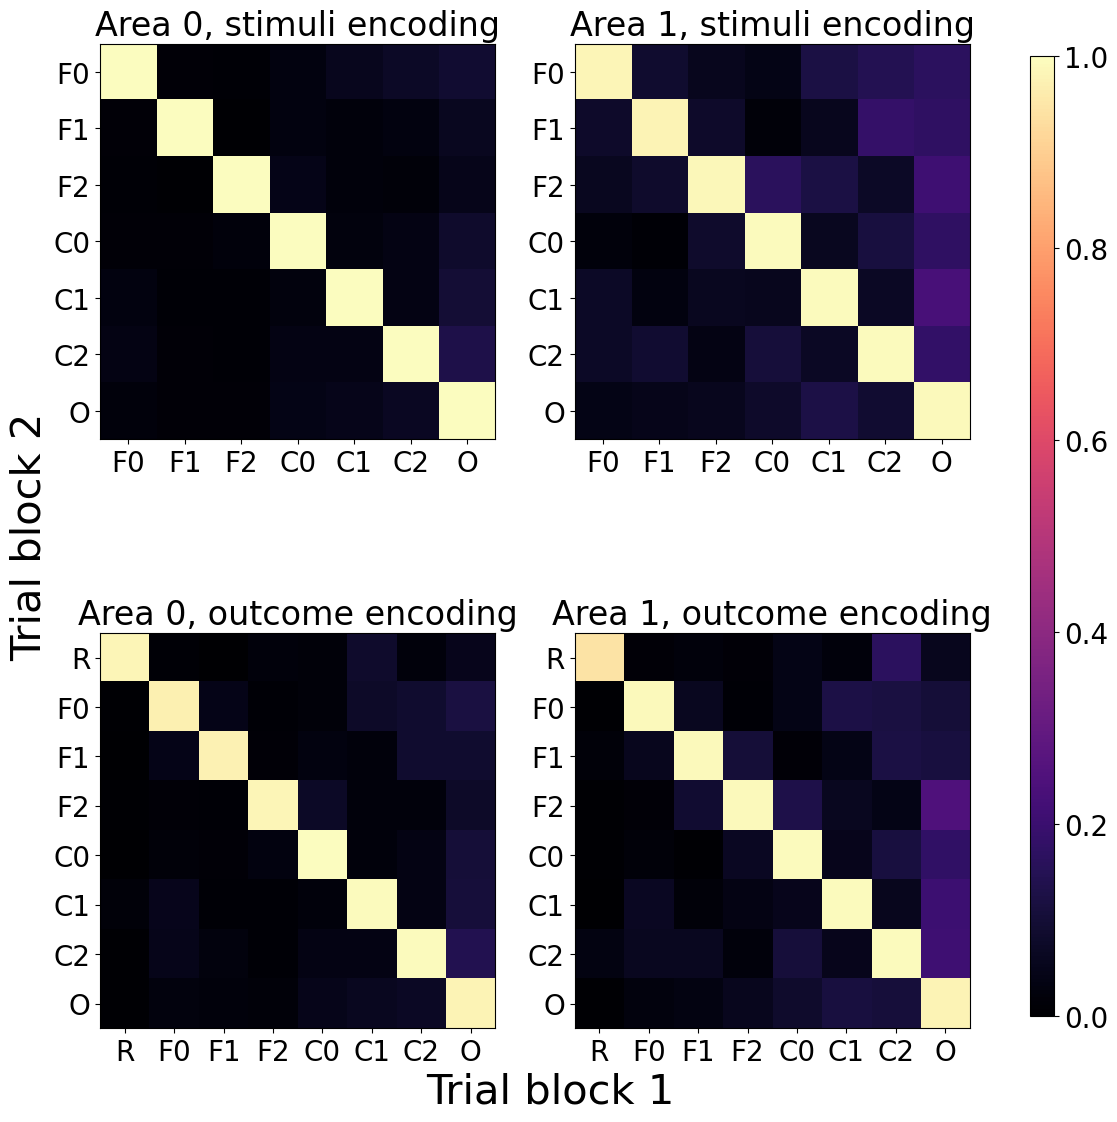

In [41]:
block_overlap = np.empty((7,7))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for area in range(2):
    for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
        for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
            block_overlap[k_curr_idx, k_prev_idx] = \
                np.sum((dpca_results_by_curr_stim_split[0][area]['encoding_axes']['t'+k_prev].T@\
                        dpca_results_by_curr_stim_split[1][area]['encoding_axes']['t'+k_curr])**2)/\
                dpca_results_by_curr_outcome_split[0][area]['encoding_axes']['t'+k_curr].shape[1]
        cm = axes[0,area].imshow(block_overlap, vmin=0, vmax=1, cmap='magma')  
        axes[0,area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
        axes[0,area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
        axes[0,area].set_title(f'Area {area}, stimuli encoding')
        
block_overlap = np.empty((8,8))
for area in range(2):
    for k_prev_idx, k_prev in enumerate(['r','s','p','c','pc','sc','sp','spc']):
        for k_curr_idx, k_curr in enumerate(['r','s','p','c','pc','sc','sp','spc']):
            block_overlap[k_curr_idx, k_prev_idx] = \
                np.sum((dpca_results_by_curr_outcome_split[0][area]['encoding_axes']['t'+k_prev].T@\
                        dpca_results_by_curr_outcome_split[1][area]['encoding_axes']['t'+k_curr])**2)/\
                dpca_results_by_curr_outcome_split[0][area]['encoding_axes']['t'+k_curr].shape[1]
        cm = axes[1,area].imshow(block_overlap, vmin=0, vmax=1, cmap='magma') 
        axes[1,area].set_xticks(np.arange(8),["R","F0", "F1", "F2", "C0", "C1", "C2", "O"])
        axes[1,area].set_yticks(np.arange(8),["R","F0", "F1", "F2", "C0", "C1", "C2", "O"])
        axes[1,area].set_title(f'Area {area}, outcome encoding')
        
fig.supxlabel("Trial block 1", fontsize=30, y=0.02)
fig.supylabel("Trial block 2", fontsize=30, x=0.05)
plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


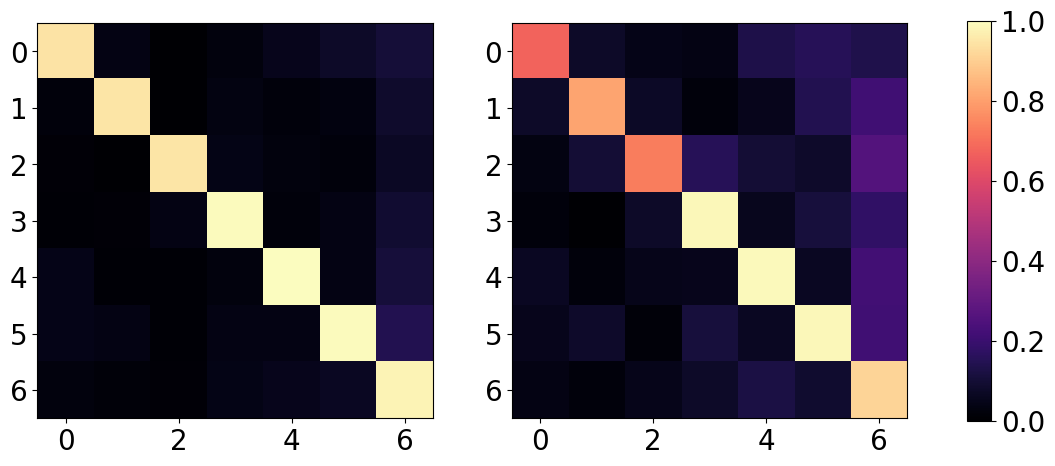

In [42]:
prev_curr_overlap = np.empty((7,7))

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for area in range(2):
    for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
        for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
            prev_curr_overlap[k_curr_idx, k_prev_idx] = \
                np.sum((dpca_results_by_curr_outcome[area]['encoding_axes']['t'+k_prev].T@\
                        dpca_results_by_curr_stim[area]['encoding_axes']['t'+k_curr])**2)/\
                dpca_results_by_curr_stim[area]['encoding_axes']['t'+k_curr].shape[1]
        cm = axes[area].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')  

plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


# plt.tight_layout()


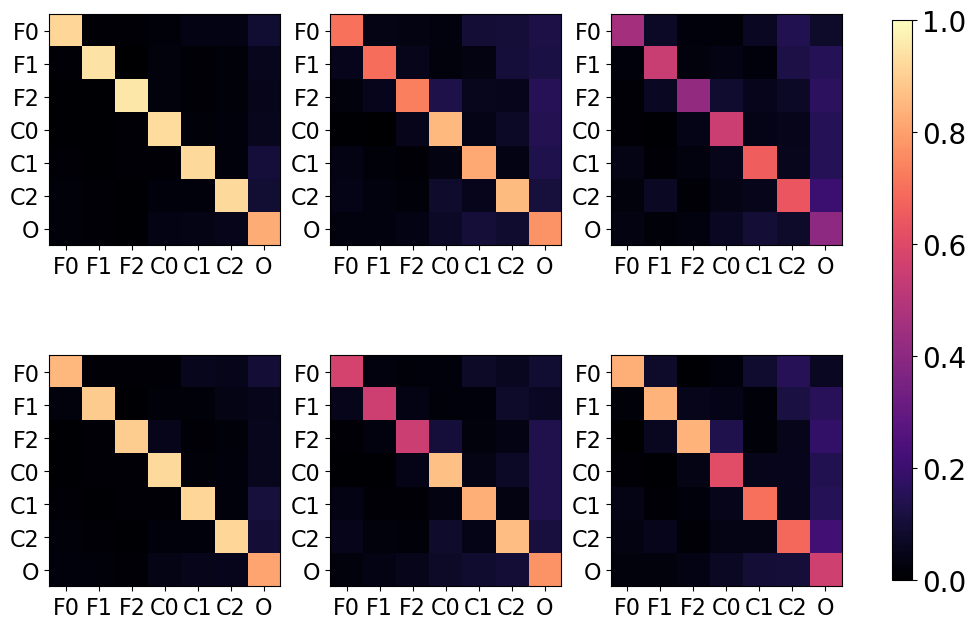

In [43]:
prev_curr_overlap = np.empty((7,7))

fig, axes = plt.subplots(2, 3)

area=0
for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
        prev_curr_overlap[k_curr_idx, k_prev_idx] = \
            np.sum((dpca_in.P[k_prev].T@dpca_results_by_curr_stim[0]['encoding_axes']['t'+k_curr])**2)/\
            dpca_results_by_curr_stim[0]['encoding_axes']['t'+k_curr].shape[1]
cm = axes[0,0].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')

for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
        prev_curr_overlap[k_curr_idx, k_prev_idx] = \
            np.sum((dpca_out.P[k_prev].T@dpca_results_by_curr_stim[1]['encoding_axes']['t'+k_curr])**2)/\
            dpca_results_by_curr_stim[1]['encoding_axes']['t'+k_curr].shape[1]
cm = axes[0,1].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')

for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
        prev_curr_overlap[k_curr_idx, k_prev_idx] = \
            np.sum((dpca_ch.P[k_prev].T@dpca_results_by_curr_stim[1]['encoding_axes']['t'+k_curr])**2)/\
            dpca_results_by_curr_stim[1]['encoding_axes']['t'+k_curr].shape[1]
cm = axes[0,2].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')
    
for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
        prev_curr_overlap[k_curr_idx, k_prev_idx] = \
            np.sum((dpca_in.P[k_prev].T@dpca_results_by_curr_outcome[0]['encoding_axes']['t'+k_curr])**2)/\
            dpca_results_by_curr_outcome[0]['encoding_axes']['t'+k_curr].shape[1]
cm = axes[1,0].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')

for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
        prev_curr_overlap[k_curr_idx, k_prev_idx] = \
            np.sum((dpca_out.P[k_prev].T@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+k_curr])**2)/\
            dpca_results_by_curr_outcome[1]['encoding_axes']['t'+k_curr].shape[1]
cm = axes[1,1].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')

for k_prev_idx, k_prev in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_curr_idx, k_curr in enumerate(['s','p','c','pc','sc','sp','spc']):
        prev_curr_overlap[k_curr_idx, k_prev_idx] = \
            np.sum((dpca_ch.P[k_prev].T@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+k_curr])**2)/\
            dpca_results_by_curr_outcome[1]['encoding_axes']['t'+k_curr].shape[1]
cm = axes[1,2].imshow(prev_curr_overlap, vmin=0, vmax=1, cmap='magma')

    
plt.tight_layout()


for i in range(2):
    for j in range(3):
        axes[i,j].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=16)
        axes[i,j].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=16)

plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)



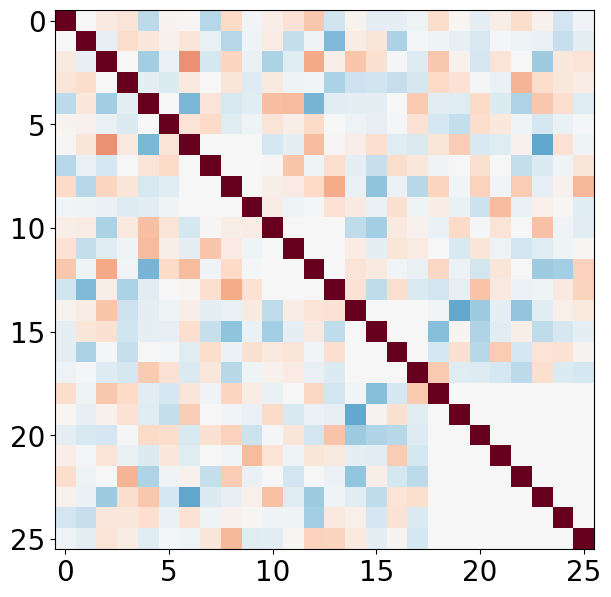

In [195]:
all_dpca_axes_prev = np.concatenate([dpca_results_by_prev[0]['encoding_axes']['ts'], 
                                     dpca_results_by_prev[0]['encoding_axes']['tp'],
                                     dpca_results_by_prev[0]['encoding_axes']['tc'],
                                     dpca_results_by_prev[0]['encoding_axes']['tpc'],
                                     dpca_results_by_prev[0]['encoding_axes']['tsc'],
                                     dpca_results_by_prev[0]['encoding_axes']['tsp'],
                                     dpca_results_by_prev[0]['encoding_axes']['tspc']], axis=1)

plt.imshow((all_dpca_axes_prev.T@all_dpca_axes_prev), vmin=-1, vmax=1, cmap='RdBu_r')

In [92]:
print(all_saved_states['hs'].shape)
print(total_var.shape)

torch.Size([432, 58, 92, 160])
torch.Size([432, 58, 92])


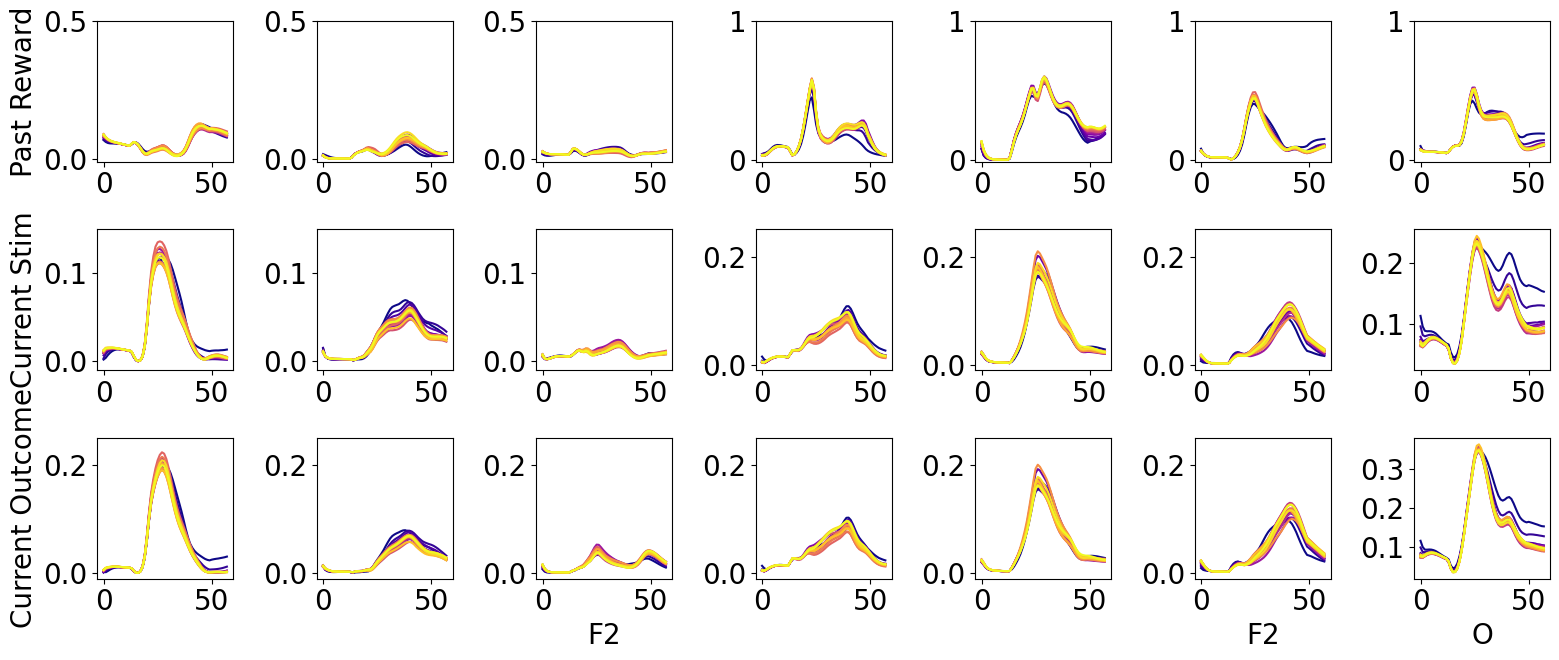

In [182]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,input_weight_inds]
total_var = (centered_hs**2).sum(-1)

fig, axes = plt.subplots(3,7, figsize=(16, 7)) # three rows for past, curr stim, curr outcome

'''past reward'''
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[0]['encoding_axes']['tr'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.5])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[0]['encoding_axes']['tr'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[0,3+conj_idx].set_ylim([-0.01, 1])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[0]['encoding_axes']['trspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[0,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
axes[0,6].set_ylim([-0.01, 1])
axes[0,0].set_ylabel('Past Reward')

    
'''curr stim''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[0]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[1,ft_idx].set_ylim([-0.01, 0.15])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[0]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,3+conj_idx].set_ylim([-0.01, 0.25])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[0]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[1,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")

axes[1,0].set_ylabel('Current Stim')
    
'''curr outcome''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[0]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[2,ft_idx].set_ylim([-0.01, 0.25])
axes[2,ft_idx].set_xlabel(f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[0]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[2,3+conj_idx].set_ylim([-0.01, 0.25])
axes[2,3+conj_idx].set_xlabel(f"F{conj_idx}")

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[0]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
axes[2,6].set_xlabel("O")    

axes[2,0].set_ylabel('Current Outcome')


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

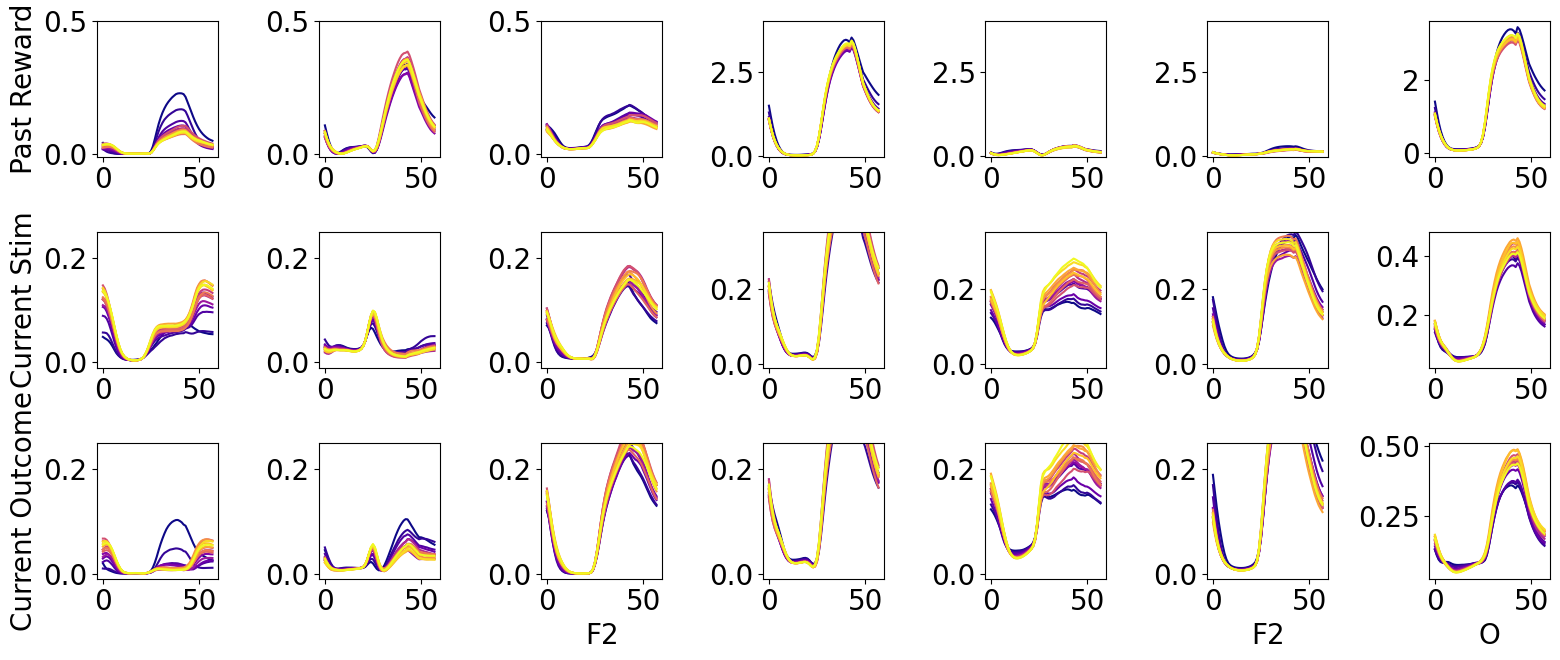

In [186]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]
total_var = (centered_hs**2).sum(-1)

fig, axes = plt.subplots(3,7, figsize=(16, 7)) # three rows for past, curr stim, curr outcome

'''past reward'''
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['tr'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.5])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['tr'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[0,3+conj_idx].set_ylim([-0.01, 4])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['trspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[0,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
# axes[0,6].set_ylim([-0.01, 1])
axes[0,0].set_ylabel('Past Reward')

    
'''curr stim''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[1,ft_idx].set_ylim([-0.01, 0.25])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,3+conj_idx].set_ylim([-0.01, 0.35])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[1,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")

axes[1,0].set_ylabel('Current Stim')
    
'''curr outcome''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[2,ft_idx].set_ylim([-0.01, 0.25])
axes[2,ft_idx].set_xlabel(f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[2,3+conj_idx].set_ylim([-0.01, 0.25])
axes[2,3+conj_idx].set_xlabel(f"F{conj_idx}")

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
axes[2,6].set_xlabel("O")    

axes[2,0].set_ylabel('Current Outcome')


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

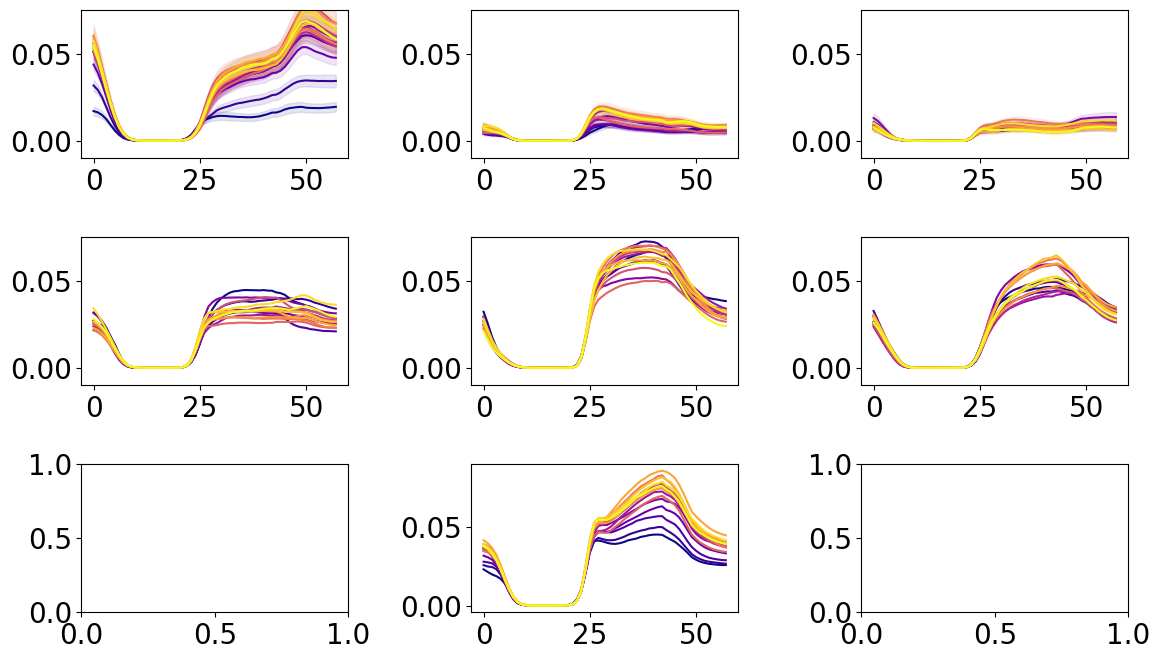

In [44]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]-\
              all_saved_states['hs'][:,:,:,output_weight_inds].mean(-1, keepdims=True)
total_var = ((centered_hs)**2).sum(-1)

fig, axes = plt.subplots(3,3, figsize=(12, 7))
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_out.P[ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        plot_mean_and_std(ax=axes[0,ft_idx], m=avg_exp_var[trials_to_plot].mean(0), 
                          sd=avg_exp_var[trials_to_plot].std(0)/np.sqrt(avg_exp_var[trials_to_plot].shape[0]),
                          color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.075])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_out.P[conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,conj_idx].set_ylim([-0.01, 0.075])


avg_exp_var = ((centered_hs.mean(2)@dpca_out.P['spc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,1].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

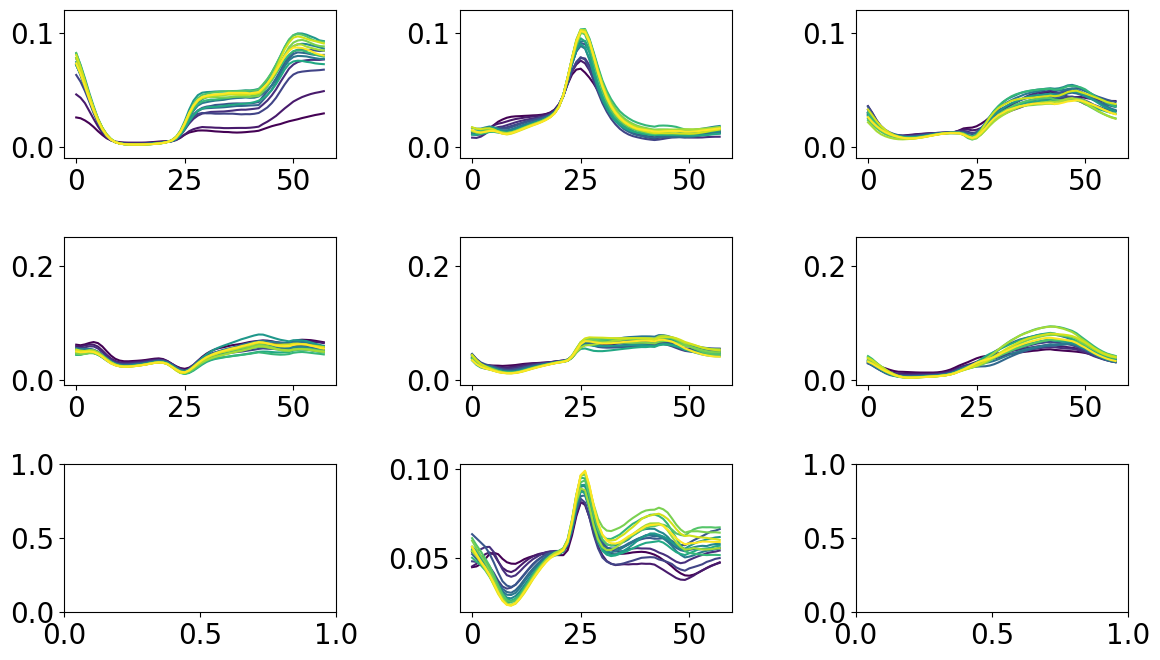

In [45]:
num_blocks = 16
colors = plt.cm.viridis(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]-\
              all_saved_states['hs'][:,:,:,output_weight_inds].mean(-1, keepdims=True)
total_var = ((centered_hs)**2).sum(-1)

fig, axes = plt.subplots(3,3, figsize=(12, 7))
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.12])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,conj_idx].set_ylim([-0.01, 0.25])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,1].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

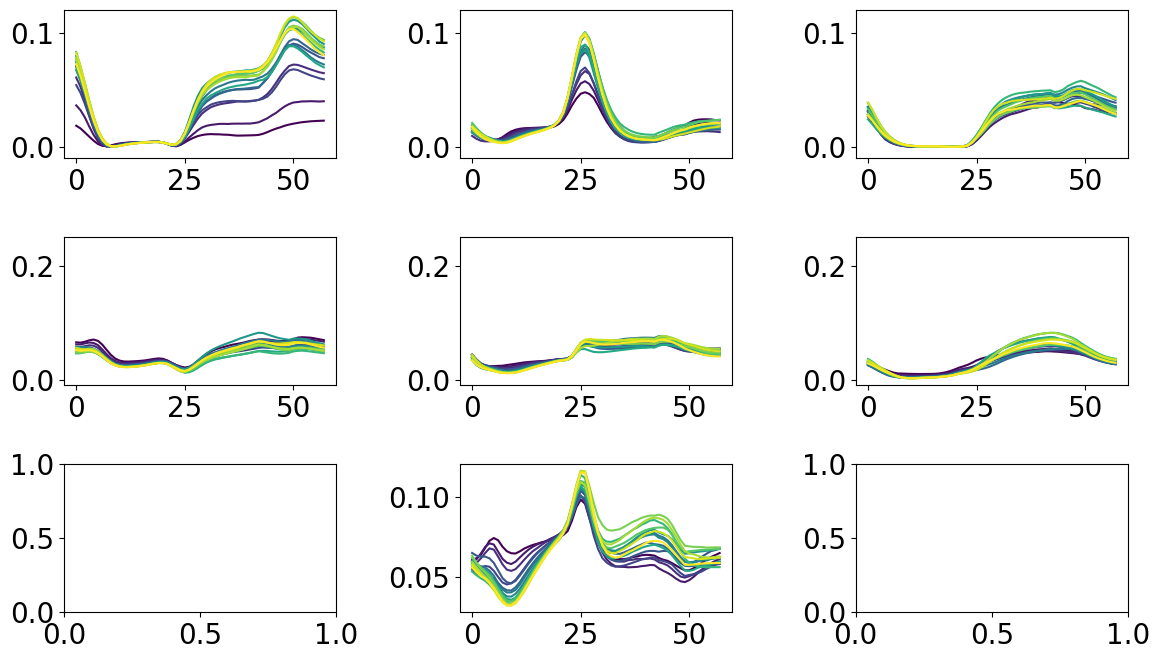

In [46]:
num_blocks = 16
colors = plt.cm.viridis(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]-\
              all_saved_states['hs'][:,:,:,output_weight_inds].mean(-1, keepdims=True)
total_var = ((centered_hs)**2).sum(-1)

fig, axes = plt.subplots(3,3, figsize=(12, 7))
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.12])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,conj_idx].set_ylim([-0.01, 0.25])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,1].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

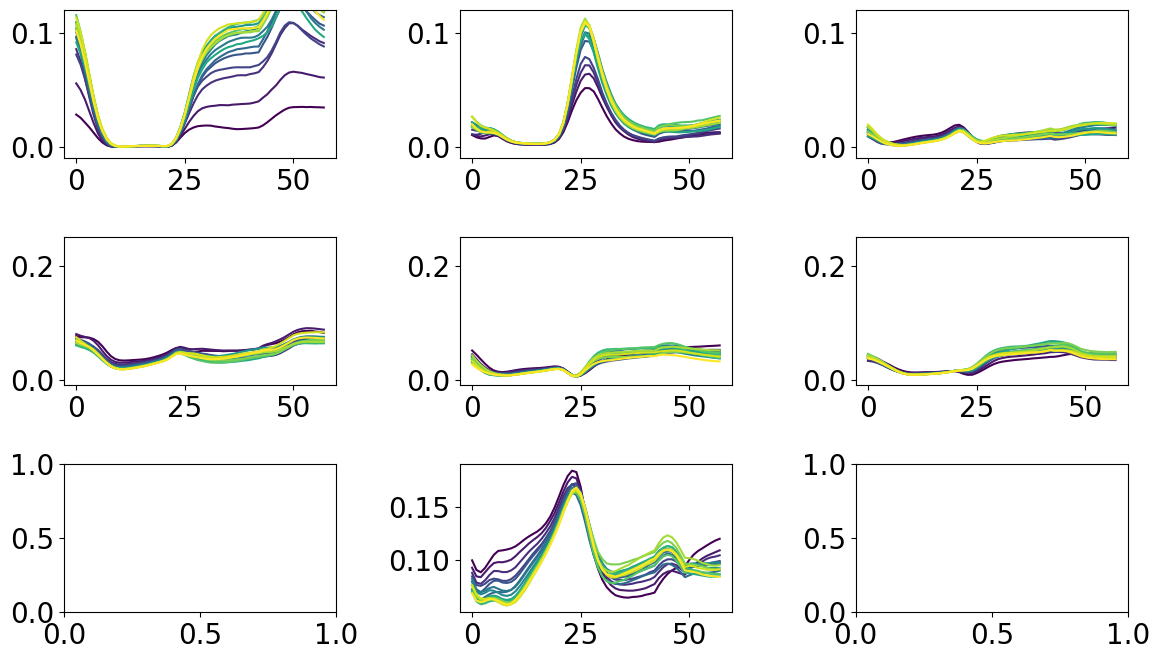

In [47]:
num_blocks = 16
colors = plt.cm.viridis(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]-\
              all_saved_states['hs'][:,:,:,output_weight_inds].mean(-1, keepdims=True)
total_var = ((centered_hs)**2).sum(-1)

fig, axes = plt.subplots(3,3, figsize=(12, 7))
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_ch.P[ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.12])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_ch.P[conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,conj_idx].set_ylim([-0.01, 0.25])

avg_exp_var = ((centered_hs.mean(2)@dpca_ch.P['spc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,1].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

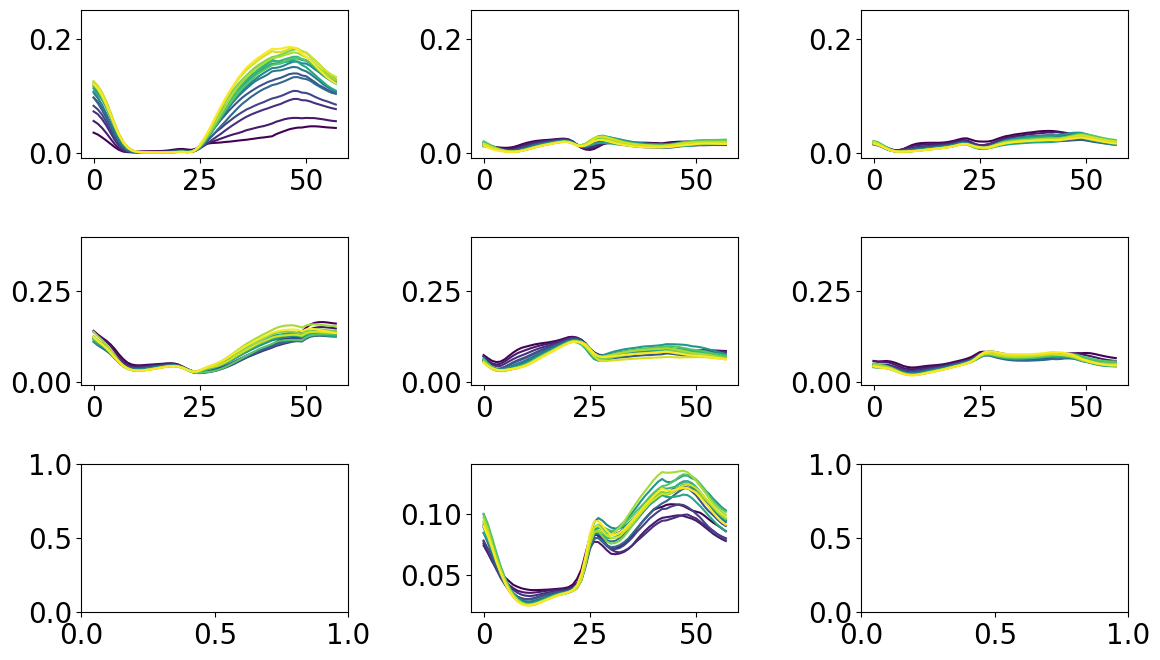

In [48]:
num_blocks = 16
colors = plt.cm.viridis(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]-\
              all_saved_states['hs'][:,:,:,output_weight_inds].mean(-1, keepdims=True)
total_var = ((centered_hs)**2).sum(-1)

fig, axes = plt.subplots(3,3, figsize=(12, 7))
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['tr'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.25])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['tr'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,conj_idx].set_ylim([-0.01, 0.4])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['trspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,1].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

Text(0, 0.5, 'Average gain')

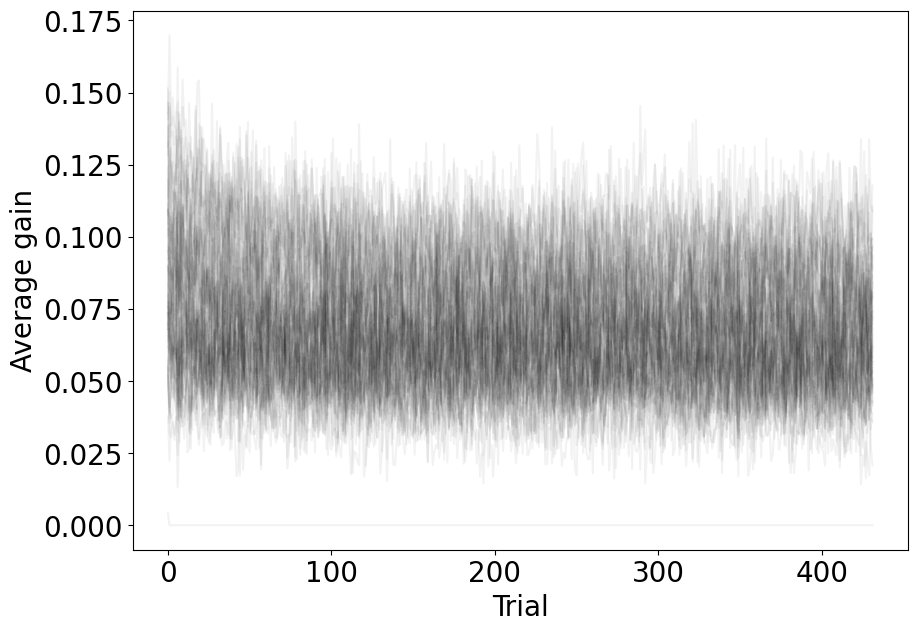

In [91]:
hs_for_gain = all_saved_states['hs'][:,:,:,:64]
plt.plot(torch.mean((hs_for_gain>0)*(1-hs_for_gain**2), dim=(1,2)), color=[0, 0, 0, 0.05]);
plt.xlabel('Trial')
plt.ylabel('Average gain')

In [57]:
print(all_saved_states['stimuli'].shape, target_obj.shape)

torch.Size([432, 1, 92, 2]) torch.Size([432, 1, 92])


In [73]:
unchosen_ft.shape

(39744, 7)

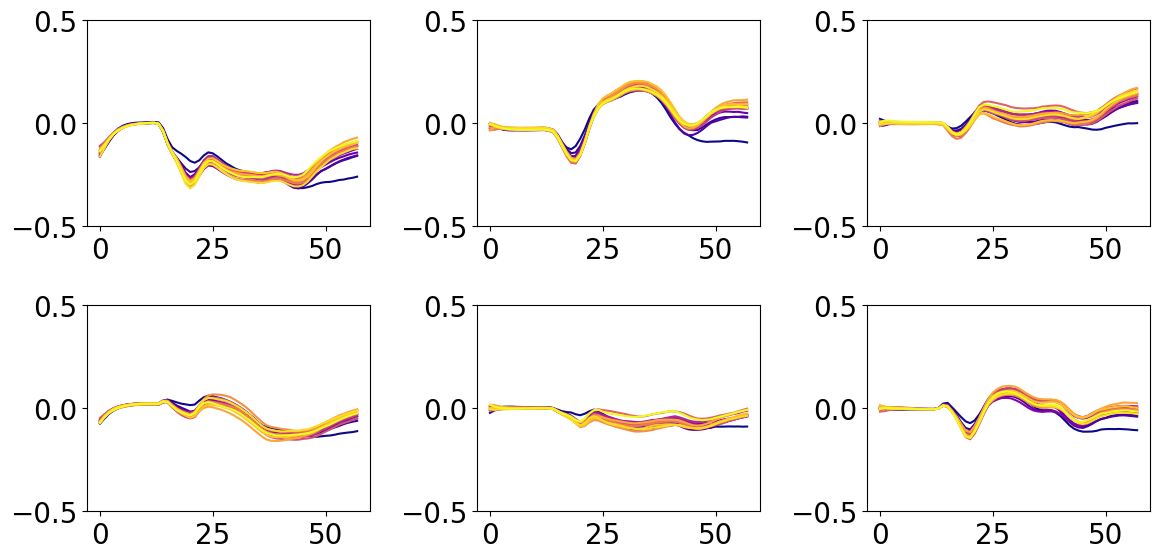

In [77]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

target_obj = torch.argmax(all_saved_states['reward_probs'], dim=-1).flatten()
flat_stims = all_saved_states['stimuli'].reshape((target_obj.shape[0], 2))
chosen_stims = flat_stims[torch.arange(len(target_obj)),target_obj]
unchosen_stims = flat_stims[torch.arange(len(target_obj)),1-target_obj]
chosen_stims = chosen_stims.reshape(all_saved_states['stimuli'].shape[:-1])
unchosen_stims = unchosen_stims.reshape(all_saved_states['stimuli'].shape[:-1])

chosen_ft = obj_to_ft_conj(chosen_stims, task_mdprl)
unchosen_ft = obj_to_ft_conj(unchosen_stims, task_mdprl)

input_hs = all_saved_states['hs'][...,input_weight_inds]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ft_idx, ft_key in enumerate(['s','p','c']):
    f_value_axis = (dpca_in.marginalized_psth[ft_key].squeeze()[:,chosen_ft[...,ft_idx]]-\
                    dpca_in.marginalized_psth[ft_key].squeeze()[:,unchosen_ft[...,ft_idx]]).transpose((1,2,3,0))
    for i in range(num_blocks):
        axes[0,ft_idx].plot((input_hs*f_value_axis).sum(-1).mean(-1)\
                          [i*args['test_N_s']//num_blocks:(i+1)*args['test_N_s']//num_blocks].mean(0), \
                          color=colors[i])
    axes[0,ft_idx].set_ylim([-0.5, 0.5])
    
for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    f_value_axis = (dpca_in.marginalized_psth[conj_key].squeeze().reshape((-1,9))[:,chosen_ft[...,conj_idx+3]]-\
                    dpca_in.marginalized_psth[conj_key].squeeze().reshape((-1,9))[:,unchosen_ft[...,conj_idx+3]]).transpose((1,2,3,0))
    for i in range(num_blocks):
        axes[1,conj_idx].plot((input_hs*f_value_axis).sum(-1).mean(-1)\
                          [i*args['test_N_s']//num_blocks:(i+1)*args['test_N_s']//num_blocks].mean(0), \
                          color=colors[i])
    axes[1,conj_idx].set_ylim([-0.5, 0.5])
    

plt.tight_layout()
plt.show()

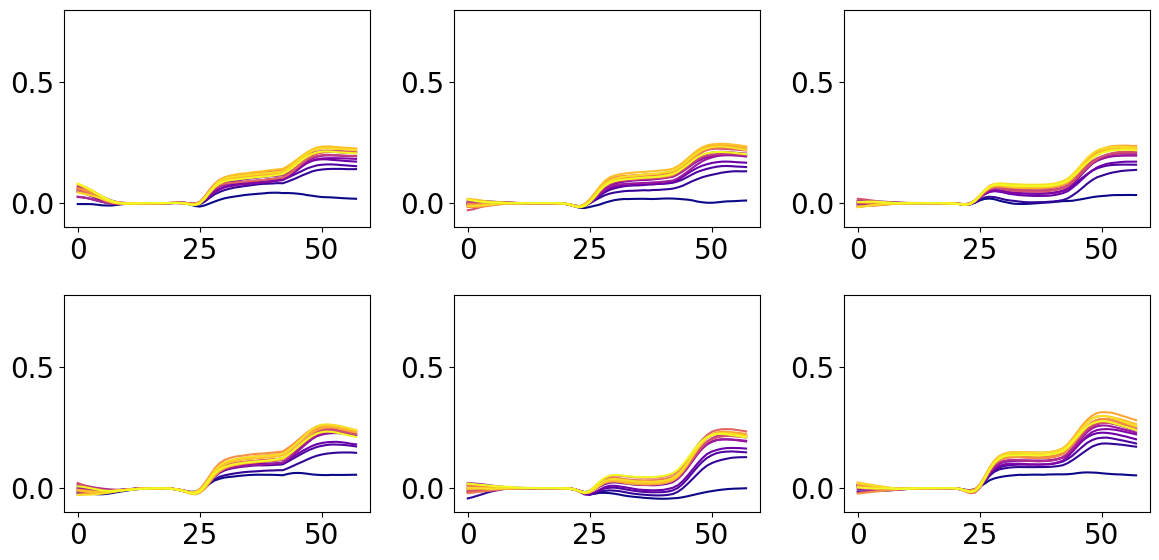

In [76]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

target_obj = torch.argmax(all_saved_states['reward_probs'], dim=-1).flatten()
flat_stims = all_saved_states['stimuli'].reshape((target_obj.shape[0], 2))
chosen_stims = flat_stims[torch.arange(len(target_obj)),target_obj]
unchosen_stims = flat_stims[torch.arange(len(target_obj)),1-target_obj]
chosen_stims = chosen_stims.reshape(all_saved_states['stimuli'].shape[:-1])
unchosen_stims = unchosen_stims.reshape(all_saved_states['stimuli'].shape[:-1])

chosen_ft = obj_to_ft_conj(chosen_stims, task_mdprl)
unchosen_ft = obj_to_ft_conj(unchosen_stims, task_mdprl)

input_hs = all_saved_states['hs'][...,output_weight_inds]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ft_idx, ft_key in enumerate(['s','p','c']):
    f_value_axis = (dpca_out.marginalized_psth[ft_key].squeeze()[:,chosen_ft[...,ft_idx]]-\
                    dpca_out.marginalized_psth[ft_key].squeeze()[:,unchosen_ft[...,ft_idx]]).transpose((1,2,3,0))
    f_value_axis = f_value_axis/np.sqrt((f_value_axis**2).sum(-1, keepdims=True))
    for i in range(16):
        axes[0,ft_idx].plot((input_hs*f_value_axis).sum(-1).mean(-1)\
                          [i*args['test_N_s']//num_blocks:(i+1)*args['test_N_s']//num_blocks].mean(0), \
                          color=colors[i])
    axes[0,ft_idx].set_ylim([-0.1, 0.8])
    
for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    f_value_axis = (dpca_out.marginalized_psth[conj_key].squeeze().reshape((-1,9))[:,chosen_ft[...,conj_idx+3]]-\
                    dpca_out.marginalized_psth[conj_key].squeeze().reshape((-1,9))[:,unchosen_ft[...,conj_idx+3]]).transpose((1,2,3,0))
    f_value_axis = f_value_axis/np.sqrt((f_value_axis**2).sum(-1, keepdims=True))
    for i in range(16):
        axes[1,conj_idx].plot((input_hs*f_value_axis).sum(-1).mean(-1)\
                          [i*args['test_N_s']//num_blocks:(i+1)*args['test_N_s']//num_blocks].mean(0), \
                          color=colors[i])
    axes[1,conj_idx].set_ylim([-0.1, 0.8])
    

plt.tight_layout()
plt.show()

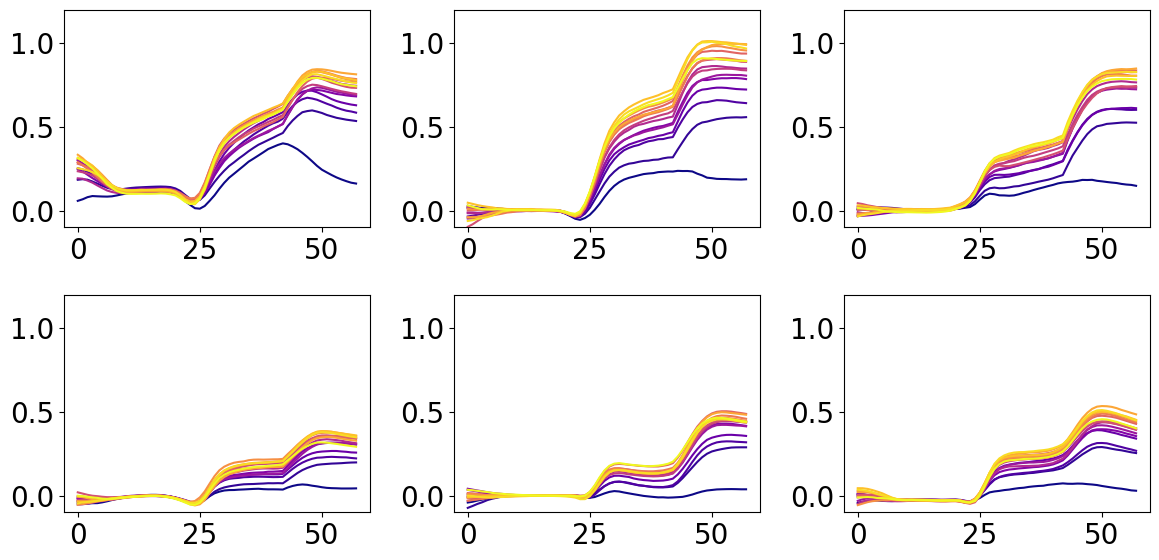

In [79]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

target_obj = torch.argmax(all_saved_states['reward_probs'], dim=-1).flatten()
flat_stims = all_saved_states['stimuli'].reshape((target_obj.shape[0], 2))
chosen_stims = flat_stims[torch.arange(len(target_obj)),target_obj]
unchosen_stims = flat_stims[torch.arange(len(target_obj)),1-target_obj]
chosen_stims = chosen_stims.reshape(all_saved_states['stimuli'].shape[:-1])
unchosen_stims = unchosen_stims.reshape(all_saved_states['stimuli'].shape[:-1])
chosen_ft = obj_to_ft_conj(chosen_stims, task_mdprl)
unchosen_ft = obj_to_ft_conj(unchosen_stims, task_mdprl)

input_hs = all_saved_states['hs'][...,output_weight_inds]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for ft_idx, ft_key in enumerate(['s','p','c']):
    f_value_axis = (dpca_ch.marginalized_psth[ft_key].squeeze()[:,chosen_ft[...,ft_idx]]-\
                    dpca_ch.marginalized_psth[ft_key].squeeze()[:,unchosen_ft[...,ft_idx]]).transpose((1,2,3,0))
    for i in range(16):
        axes[0,ft_idx].plot((input_hs*f_value_axis).sum(-1).mean(-1)\
                          [i*args['test_N_s']//num_blocks:(i+1)*args['test_N_s']//num_blocks].mean(0), \
                          color=colors[i])
    axes[0,ft_idx].set_ylim([-0.1, 1.2])
    
for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    f_value_axis = (dpca_ch.marginalized_psth[conj_key].squeeze().reshape((-1,9))[:,chosen_ft[...,conj_idx+3]]-\
                    dpca_ch.marginalized_psth[conj_key].squeeze().reshape((-1,9))[:,unchosen_ft[...,conj_idx+3]]).transpose((1,2,3,0))
    for i in range(16):
        axes[1,conj_idx].plot((input_hs*f_value_axis).sum(-1).mean(-1)\
                          [i*args['test_N_s']//num_blocks:(i+1)*args['test_N_s']//num_blocks].mean(0), \
                          color=colors[i])
    axes[1,conj_idx].set_ylim([-0.1, 1.2])
    

plt.tight_layout()
plt.show()

In [538]:
all_whs = all_saved_states['whs_final'].squeeze().clamp(-1, 1)*model.rnn.h2h.mask.reshape(1,1,160,160)-\
          model.rnn.h2h.effective_weight().detach().clamp(-1, 1)
all_ff_whs = all_whs[:,:,output_weight_inds][:,:,:,input_weight_inds]
all_fb_whs = all_whs[:,:,input_weight_inds][:,:,:,output_weight_inds]
all_rec_in_whs = all_whs[:,:,input_weight_inds][:,:,:,input_weight_inds]
all_rec_out_whs = all_whs[:,:,output_weight_inds][:,:,:,output_weight_inds]

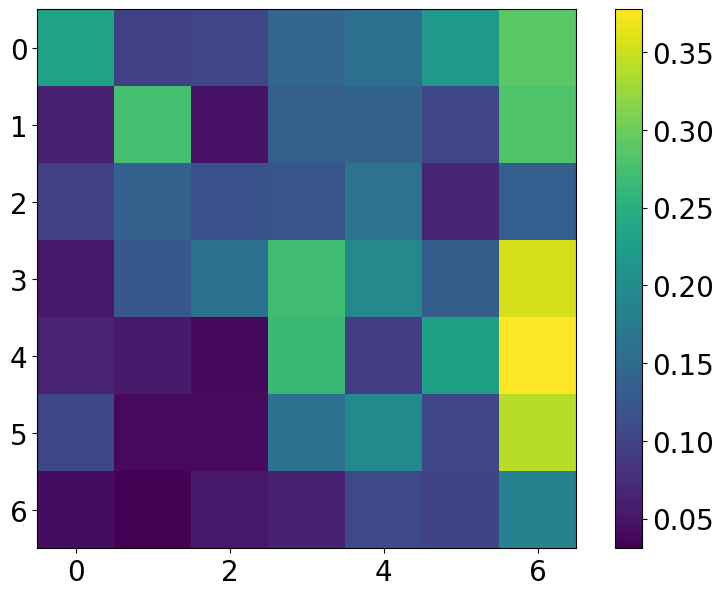

In [80]:
hebb_weight_overlaps = np.empty((7,7))

for k_in_idx, k_in in enumerate(['s','p','c','pc','sc','sp','spc']):
    for k_out_idx, k_out in enumerate(['s','p','c','pc','sc','sp','spc']):
        hebb_weight_overlaps[k_out_idx][k_in_idx] = \
            np.sum((dpca_results_by_prev[1]['encoding_axes']['tr'+k_in].T@\
                    dpca_results_by_curr_stim[1]['encoding_axes']['t'+k_out])**2)/\
            dpca_results_by_prev[1]['encoding_axes']['t'+k_out].shape[1]
            
plt.imshow(hebb_weight_overlaps)
plt.colorbar()


In [66]:
(dpca_results_by_prev[1]['encoding_axes']['tr'+k_out]@\
                    dpca_results_by_curr_stim[1]['encoding_axes']['t'+k_out].T).shape

(80, 80)

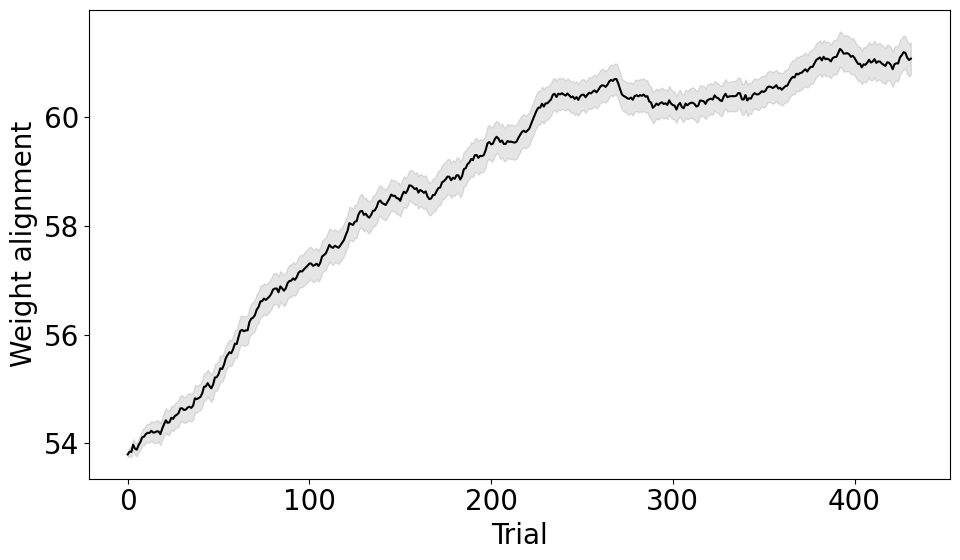

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

weight_alignment = np.trace(all_saved_states['whs_final'].squeeze()[...,64:128,:][...,:64]@\
             all_saved_states['whs_final'].squeeze()[...,:64,:][...,64:128], axis1=-2, axis2=-1)

plot_mean_and_std(ax, weight_alignment.mean(1), weight_alignment.std(1)/np.sqrt(weight_alignment.shape[1]), label=None, color='k')
            
ax.set_xlabel('Trial')
ax.set_ylabel('Weight alignment')

fig.tight_layout()

# Candidate mechanisms of modulating attention
$$
\begin{align*}
    \frac{\partial \text{logit}_s}{\partial r_{s-1}}=\underbrace{B^\top diag(\sigma'_{ })}_{\text{1.gain modulation}} 
    \underbrace{(I-W_sdiag(\sigma'_{}))^{-1}}_{\text{2.recurrence}}
    \underbrace{(A\odot(h_{s-1}h_{s-1}^{\top}))h_s}_{\text{3.routing through alignment}}
\end{align*}
$$
1. Gain modulation
2. Amplification through recurrence
2. Dynamic routing through alignment

### activity of rnn at the end of choice trials and choice presentation approximately converges, so we can simplify with implicit function

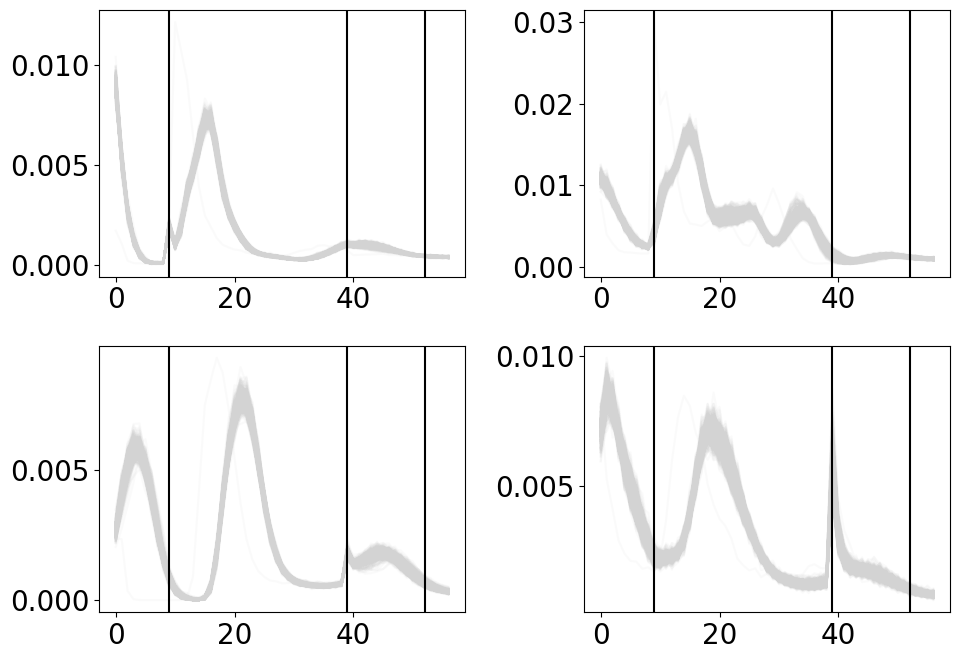

In [38]:
fig, axes = plt.subplots(2, 2)

delta_h = ((all_saved_states['hs'][:,1:,:,:]-all_saved_states['hs'][:,:-1,:,:])**2).mean(2) 
# shape = trial X time X units

axes[0,0].plot(delta_h[...,input_weight_inds[:64]].mean(-1).T, alpha=0.1, color='lightgrey');
axes[0,1].plot(delta_h[...,input_weight_inds[64:]].mean(-1).T, alpha=0.1, color='lightgrey');
axes[1,0].plot(delta_h[...,output_weight_inds[:64]].mean(-1).T, alpha=0.1, color='lightgrey');
axes[1,1].plot(delta_h[...,output_weight_inds[64:]].mean(-1).T, alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        axes[i,j].axvline(np.where(task_mdprl.T_stim)[0][0]-1, color='black')
        axes[i,j].axvline(np.where(task_mdprl.T_ch)[0][0]-1, color='black')
        axes[i,j].axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.tight_layout()


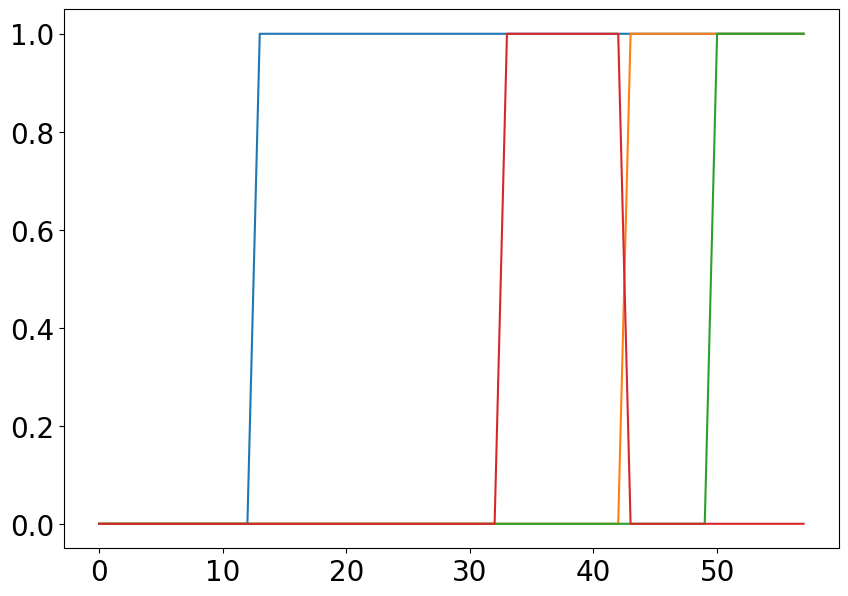

In [85]:
plt.plot(task_mdprl.T_stim)
plt.plot(task_mdprl.T_ch)
plt.plot(task_mdprl.T_rwd)
plt.plot(task_mdprl.T_mask)

## Calculate gain modulation of readout

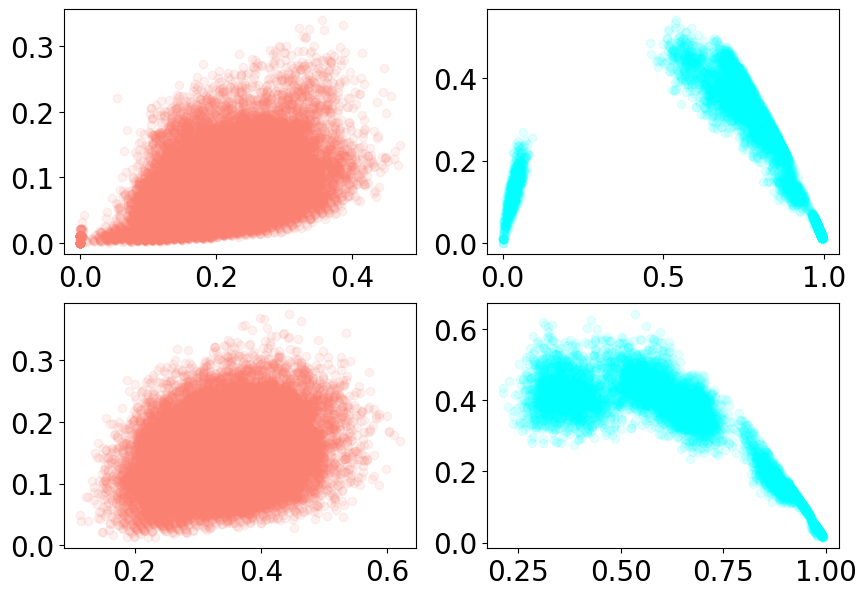

In [140]:
fig, axes = plt.subplots(2, 2)

h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_mask,:,:][:,-1,...] # activity at steady state
h_avg_lrn = all_saved_states['hs'][:,task_mdprl.T_rwd,:,:][:,-1,...] # activity at steady state
h_gain = ((h_avg_ch>0).float()*(1-h_avg_ch**2)) # gain at steady state

axes[0,0].scatter(h_avg_ch[:,:,input_weight_inds[:64]].mean(1), h_gain[:,:,input_weight_inds[:64]].mean(1), 
                  alpha=0.1, c='salmon')
# axes[0,0].imshow(h_gain[:,input_weight_inds[:64]].T, aspect='auto')
    
axes[0,1].scatter(h_avg_ch[:,:,input_weight_inds[64:]].mean(1), h_gain[:,:,input_weight_inds[64:]].mean(1), 
                  alpha=0.1, c='cyan')
# axes[0,1].imshow(h_gain[:,input_weight_inds[64:]].T, aspect='auto')
    
axes[1,0].scatter(h_avg_ch[:,:,output_weight_inds[:64]].mean(1), h_gain[:,:,output_weight_inds[:64]].mean(1), 
                  alpha=0.1, c='salmon')
# axes[1,0].imshow(h_gain[:,output_weight_inds[:64]].T, aspect='auto')

axes[1,1].scatter(h_avg_ch[:,:,output_weight_inds[64:]].mean(1), h_gain[:,:,output_weight_inds[64:]].mean(1), 
                  alpha=0.1, c='cyan')
# axes[1,1].imshow(h_gain[:,output_weight_inds[64:]].T, aspect='auto')


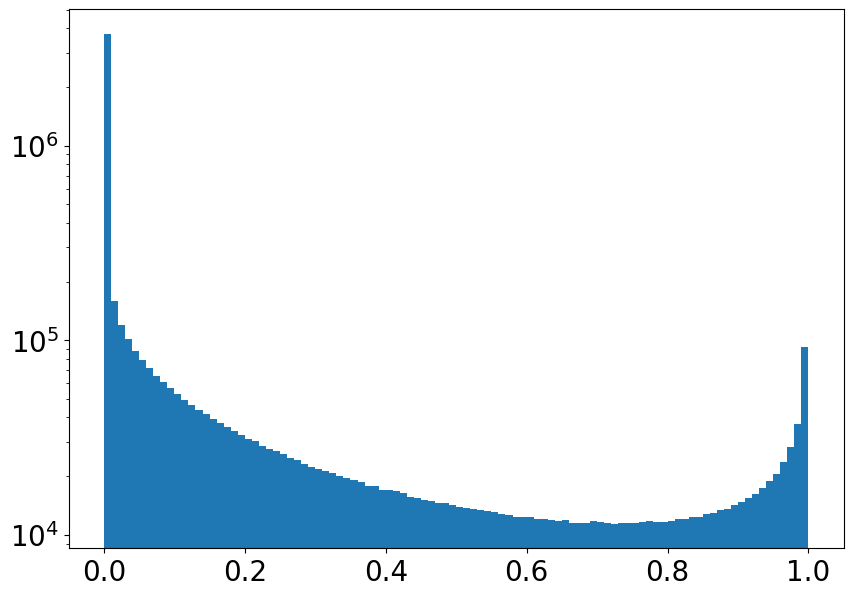

In [148]:
plt.hist(h_gain[:,:,:].flatten(), bins=100, log=True);

In [196]:
h2o_gain_mod = h_gain[:,:,None,output_weight_inds[:64]]*model.h2o.effective_weight().detach()[None,None,...]

h2o_gain_mod_variance_ratio = np.empty((432, 92, 7))

for idx_trial in tqdm.tqdm(range(432)):
    for idx_sess in range(92):
        dpca_out_gain_mod = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
        low_output = dpca_out_gain_mod.fit_transform(h2o_gain_mod[idx_trial,idx_sess].numpy().T.reshape((E_SIZE,3,3,3)))
        for idx_k, k in enumerate(['s','p','c','pc','sc','sp','spc']):
            h2o_gain_mod_variance_ratio[idx_trial, idx_sess, idx_k] = np.sum(dpca_out_gain_mod.explained_variance_ratio_[k])


100%|██████████| 432/432 [01:54<00:00,  3.79it/s]


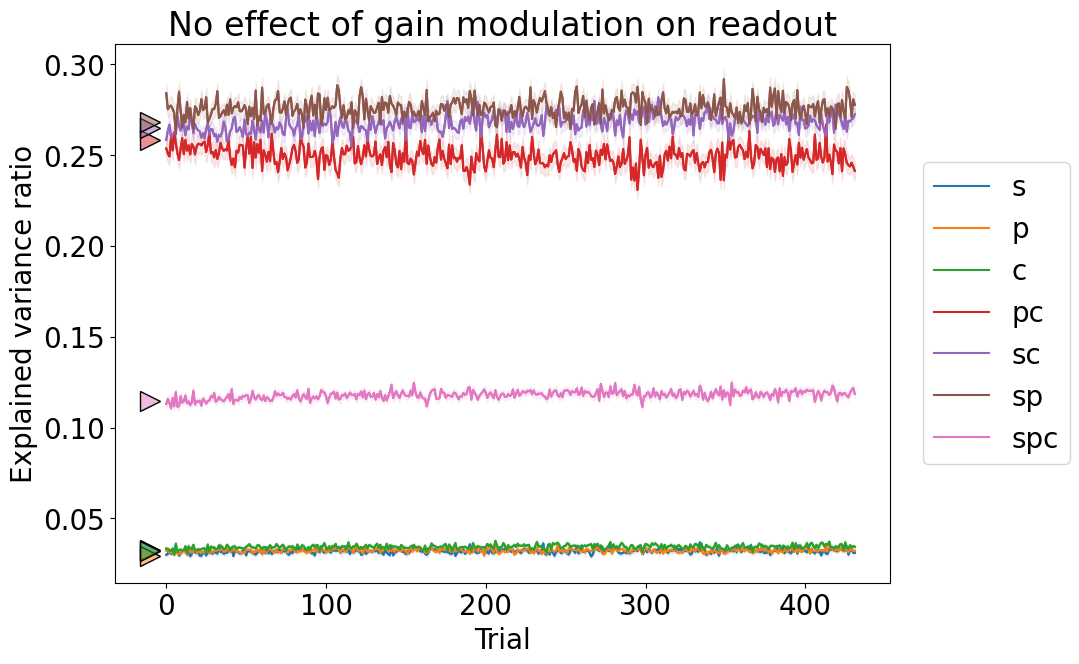

In [280]:
plt.plot(h2o_gain_mod_variance_ratio.mean(1))
ax = plt.subplot()

for idx_k, k in enumerate(['s','p','c','pc','sc','sp','spc']):
    ax.plot(-10, np.sum(dpca_out.explained_variance_ratio_[k]), marker='>', 
            markeredgecolor='k', markerfacecolor=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,0.5]),
           markersize=15)
    plot_mean_and_std(ax=ax,
                      m=h2o_gain_mod_variance_ratio[...,idx_k].mean(1), 
                      sd=h2o_gain_mod_variance_ratio[...,idx_k].std(1)/np.sqrt(92),
                      label=k, color=mpl.colormaps['tab10'](idx_k))
ax.set_xlabel('Trial')
ax.set_ylabel('Explained variance ratio')
ax.set_title('No effect of gain modulation on readout')
ax.legend(bbox_to_anchor=(1.25, 0.5), loc='center right')

In [277]:
mpl.colormaps['tab10'](idx_k)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

## recurrence through plastic weights

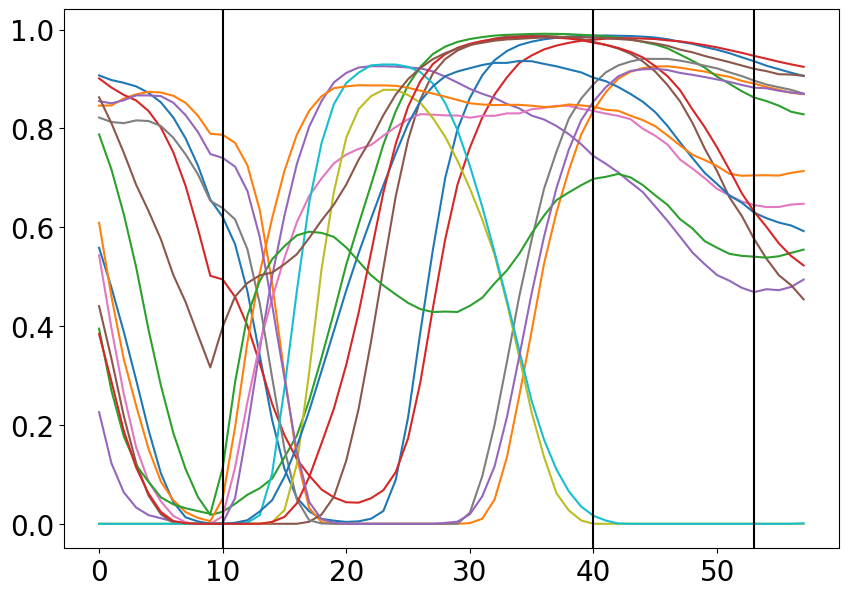

In [45]:
plt.plot(all_saved_states['hs'][40,:,:,128:144].mean(1));
plt.axvline(np.where(task_mdprl.T_stim)[0][0], color='black')
plt.axvline(np.where(task_mdprl.T_ch)[0][0], color='black')
plt.axvline(np.where(task_mdprl.T_rwd)[0][0], color='black')
# plt.colorbar()

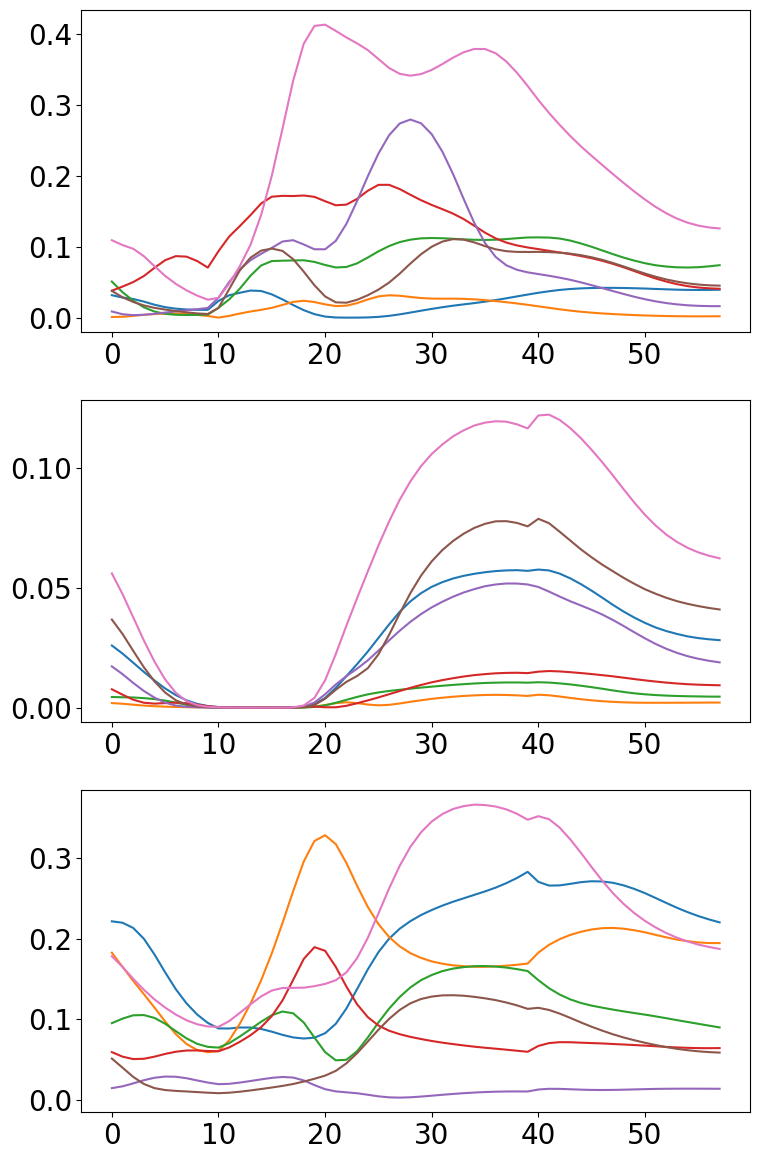

In [46]:
# ttt=np.arange(0, 80)

fig, axes = plt.subplots(3,1, figsize=(8, 12))
for k_idx, k in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
    axes[0].plot(((all_saved_states['hs'][:][:,:,:,input_weight_inds].mean((0,2))@dpca_in.P[k])**2).sum(-1));
    axes[1].plot(((all_saved_states['hs'][:][:,:,:,output_weight_inds].mean((0,2))@dpca_out.P[k])**2).sum(-1));
    axes[2].plot(((all_saved_states['hs'][:][:,:,:,output_weight_inds].mean((0,2))@dpca_ch.P[k])**2).sum(-1));
    
fig.tight_layout()

# print(obj_to_ft_conj(all_saved_states['choices'][ttt,:,iii], task_mdprl))
# print(obj_to_ft_conj(all_saved_states['foregone'][ttt,:,iii], task_mdprl))
# print(all_saved_states['rewards'][ttt,:,iii])
# print(obj_to_ft_conj(all_saved_states['stimuli'][ttt,:,iii], task_mdprl))
# print(obj_to_value_est(all_saved_states['stimuli'][ttt,:,iii], task_mdprl))